# TheKeys

TheKeys will be a web based service that helps individuals or families moving to a new area under the premise of being recruited to work for a mid to large size corporation, as well as help those same corporations stay well informed of the housing market of their perspective and current employees to help them with offering adequate compensation to those employees given the housing options available.

The first beta for this service will be for King County, WA, which is the home many large corporations including Amazon, Starbucks, and Microsoft, plus many mid sized corporations that can be reviewed  [here.](https://en.wikipedia.org/wiki/List_of_companies_based_in_Seattle)

The following workbook and analysis is phase one in establishing a predictive model for pricing and assisting in choosing houses for clients.

The King County Housing Dataset will be used for the analysis and a multivariate linear regression model will be used to predict housing prices.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from haversine import haversine

%run BidirectionalStepwiseSelection.ipynb

## Set Flags

In [2]:
# whether or not to run the stepwise selection function when running the notebook
# it takes a bit of time
run_stepwise_selection = True

## Read in Data

In [3]:
df = pd.read_csv('datasets/kc_house_data.csv')

## EDA

EDA was done in a separate notebook.  [EDA.ipynb](EDA.ipynb)

Any pre-processing done during EDA is placed in the function below.

### pre-process data

In [4]:
def pre_process_data(data):
    """Convert String columns to numeric/data, and fill Nan values"""
    # type conversion
    data.loc[data.sqft_basement == '?', 'sqft_basement'] = '0'
    data.sqft_basement = data.sqft_basement.astype(float)
    
    data.date = pd.to_datetime(data.date)
    
    # fill Nan values
    data.waterfront.fillna(0.0, inplace=True)
    data.view.fillna(0.0, inplace=True)
    data.yr_renovated.fillna(0.0, inplace=True)
    
    # drop 'bad data'
    data.drop_duplicates(subset='id', keep='last', inplace=True)
    data.drop(data[data.bedrooms == 33].index, inplace=True)
    data.drop(data[data.id == 2991000160].index, inplace=True)
    
    return data

In [5]:
df_clean = pre_process_data(df)

## New Continuous Features

### Distance from City Center

calculate the distance from the center of the major cities in King County and store the min distance

In [6]:
# calculate the distance from the center of the major cities in King County
df_clean['lat_long'] = tuple(zip(df_clean.lat, df_clean.long))
    
seattle = [47.6092,-122.3363]
bellevue = [47.61555,-122.20392]
kirkland = [47.6769, -122.2060]
redmond = [47.6740, -122.1215]

def calc_distances(lat_long, city):
    """
    Calculate the haversine distances from the locations in lat_long and city
    Parameters:
    lat_long: pd.series of lat/long tuples
    city: the lat/long tuple of a city
    """
    dists = []
    for loc in lat_long:
        dists.append(haversine((city),(loc),unit='mi'))
    return pd.Series(dists, index=df_clean.index)

df_clean['d_from_s'] = calc_distances(df_clean['lat_long'], seattle)
df_clean['d_from_b'] = calc_distances(df_clean['lat_long'], bellevue)
df_clean['d_from_k'] = calc_distances(df_clean['lat_long'], kirkland)
df_clean['d_from_r'] = calc_distances(df_clean['lat_long'], redmond)

df_clean['dist_from_city'] = df_clean[['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r']].min(axis=1, numeric_only=True)

df_clean.drop(['d_from_b', 'd_from_s', 'd_from_k', 'd_from_r', 'lat_long'], axis=1, inplace=True)

### Age of house

In [7]:
def house_age(row):
    """
    Return the number of years in decimal between when the house was built 
    and when it was sold
    """
    # convert yr_built to date_time
    yr_built = pd.to_datetime(row['yr_built'], format='%Y')
    return (row['date'] - yr_built).days / 365


df_clean['house_age'] = df_clean.apply(house_age, axis=1)

In [8]:
df_clean.house_age.describe()

count    21418.000000
mean        43.763394
std         29.409853
min         -0.619178
25%         17.969178
50%         39.768493
75%         63.382877
max        115.435616
Name: house_age, dtype: float64

## Categorical Features

Normally the categorical features would be dealt with after a test train split has been done, but with the tools available for this project, it must be done before the split so that all the categories can be made.

### Category Helper Functions

In [9]:
def df_ohe(data, col, prefix=''):
    """
    Create One Hot Encoded (OHE) features for a column and 
    return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    """
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [10]:
def make_category(data, col):
    """
    Make a dataframe column a category and perform a One Hot Encoding on it,
    and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column in dataframe for OHE process
    prefix: prefix to add the the new columns
    
    """
    suffix='_encoded'
    lb_make = LabelEncoder()
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

In [11]:
def define_bins(data, col, num_quantiles):
    """
    Define bins for a dataframe column based on a number of quantiles
    
    Parameters:
    data: dataframe
    col: column to be binned
    num_quantiles: number of quantiles for binning
    """
    
    q_interval = 1 / num_quantiles
    current_q = 0
    quantile_list = []
    
    for q in range(num_quantiles + 1):
        quantile_list.append(current_q)
        current_q = round(current_q + q_interval, 2)
    quantiles = data[col].quantile(quantile_list)
    
    return quantiles

In [12]:
def visualize_bins(data, col, quantiles):
    """
    Produce a histogram showing quantile splits
    
    Parameters:
    data: dataframe
    col: column
    quantiles: values for each quantile in col
    """
    fig, ax = plt.subplots()
    data[col].hist(bins='auto', color='#A9C5D3', 
                                 edgecolor='black', grid=False)
    for quantile in quantiles:
        qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)

In [13]:
def create_bins(data, col, bins):
    """
    Bin and One Hot Encode a dataframe column, and return the updated dataframe
    
    Parameters:
    data: dataframe
    col: column
    bins: array of where to split the data in col
    """
    
    col_binned = pd.cut(data[col], bins)
    binned_name = col+'_binned'
    data[binned_name] = col_binned
    data = data.drop(col, axis=1)
    data = df_ohe(data, binned_name, col)
    
    return data

### Simple Categories

In [14]:
simple_cat_data_cols = ['view','waterfront']

In [15]:
for col in simple_cat_data_cols:
    df_clean = make_category(df_clean, col)

### Complex Categories

#### yr_renovated and yr_built - had_reno

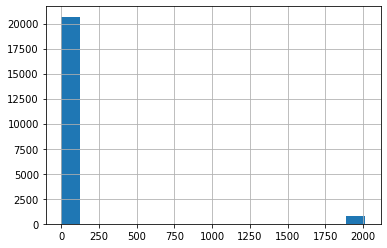

In [16]:
df_clean.yr_renovated.hist(bins='auto')

In [17]:
renovated_houses = df_clean[df_clean.yr_renovated >= df_clean.yr_built.min()]

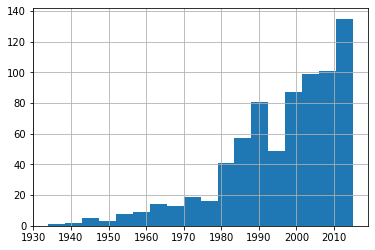

In [18]:
renovated_houses.yr_renovated.hist(bins='auto')

In [19]:
len(renovated_houses)

740

In [20]:
renovated_houses.id.nunique()

740

In [21]:
renovated_houses.id.value_counts()

2804100095    1
2131701075    1
1556200155    1
3179101580    1
3323069045    1
             ..
7950302890    1
6430000275    1
3450300280    1
9201000100    1
9297300480    1
Name: id, Length: 740, dtype: int64

There are very few renovated houses in the dataset, but it is potentially valuable info for those houses.

I will create a two new features
* yr_updated that will be the year built or the most recent renovation, which will be binned into 4 quantiles
* had_reno that will be a boolean indicating if a renovation ever occurred

yr_renovated and yr_built will not be included in the model directly

In [22]:
def had_reno(yr_renovated):
    """Return 0 if no renovation, 1 otherwise"""
    if yr_renovated == 0:
        return 0
    else:
        return 1

In [23]:
df_clean['had_reno'] = df_clean.yr_renovated.apply(had_reno)

In [24]:
df_clean = make_category(df_clean, 'had_reno')

In [25]:
def get_year_updated(row):
    """ Return the newer of yr_built or yr_renovated for a row"""
    if (row['yr_renovated'] == 0):
        year = row['yr_built']
    else:
        year = row['yr_renovated']
    
    return year

In [26]:
df_clean['yr_updated'] = df_clean.apply(get_year_updated, axis=1)

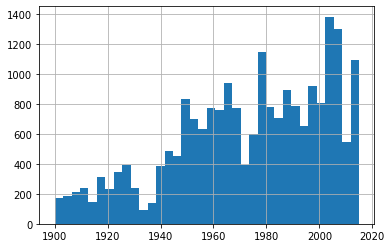

In [27]:
df_clean.yr_updated.hist(bins='auto')

In [28]:
yr_updated_bins = define_bins(df_clean, 'yr_updated', 4)

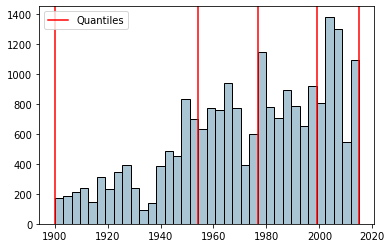

In [29]:
visualize_bins(df_clean, 'yr_updated', yr_updated_bins)

In [30]:
df_clean = create_bins(df_clean, 'yr_updated', yr_updated_bins)

#### Condition

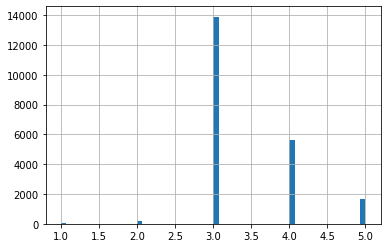

In [31]:
df_clean.condition.hist(bins='auto')

In [32]:
df_clean.condition.value_counts()

3    13899
4     5643
5     1686
2      162
1       28
Name: condition, dtype: int64

In [33]:
df_clean = df_ohe(df_clean, 'condition', 'condition')

#### zipcode

In [34]:
df_clean = df_ohe(df_clean, 'zipcode')

#### Date - Season Sold

While the sale date does not have a correlation witht the sale price, 
it seems probable that houses on the waterfront would sell better in 
warmer months.

I will create a new feature called season by extracting it from the sale date.

In [35]:
df_clean['sale_month'] = df_clean.date.apply(lambda date: date.month)

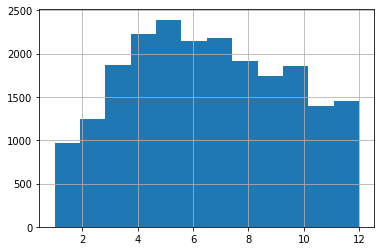

In [36]:
df_clean['sale_month'].hist(bins=12)

In [37]:
df_clean['sale_month'].value_counts()

5     2393
4     2229
7     2187
6     2150
8     1913
3     1875
10    1854
9     1747
12    1457
11    1396
2     1244
1      973
Name: sale_month, dtype: int64

the months of the year will be split into 3 seasons based on the highest sales volumes per month and knowledge of the weather in King County (better weather more sales)

In [38]:
def make_season(month):
    """Return a category value based on month"""
    winter = (11, 12, 1, 2)
    spring = (3, 4, 5, 6)
    summer = (7, 8, 9, 10)
    if month in winter:
        cat = 0
    elif month in spring:
        cat = 1
    else:
        cat = 2
        
    return cat

In [39]:
df_clean['season'] = df_clean.sale_month.apply(lambda month: make_season(month))

In [40]:
df_clean = make_category(df_clean, 'season')

In [41]:
df_clean = df_clean.drop('sale_month', axis=1)

#### Date - New Build

In [42]:
df_clean['year_sold'] = df_clean.date.apply(lambda date: date.year)

In [43]:
df_clean['new_build'] = df_clean['year_sold'] == df_clean['yr_built']

# drop uneeded temp column
df_clean = df_clean.drop('year_sold', axis=1)

In [44]:
df_clean = make_category(df_clean, 'new_build')

#### Floors - Split Level Flag

In [45]:
def in_split_level(floors):
    """Return whether the number of floors indicates a split level house"""
    split_levels = {1.5, 2.5, 3.5}
    if floors in split_levels:
        return 0
    else:
        return 1

df_clean['split_level'] = df_clean.floors.apply(in_split_level)


In [46]:
df_clean = make_category(df_clean, 'split_level')

#### sqft_basement - Flag

In [47]:
def has_basement(sqft_basement):
    """Return whether the house has a basement"""
    if sqft_basement == 0.0:
        return 0
    else:
        return 1

df_clean['has_basement'] = df_clean.sqft_basement.apply(has_basement)

df_clean = make_category(df_clean, 'has_basement')


### Flag for urban

5 miles or less from a city center

In [48]:
def is_urban(distance):
    """return if the distance is 5 or less from the center of a city"""
    if distance >=5:
        return 0
    else:
        return 1
        
df_clean['urban'] = df_clean.dist_from_city.apply(is_urban)

In [49]:
df_clean = make_category(df_clean, 'urban')

## Model Helper Functions

In [50]:
def lin_reg_sklearn(X_train, X_test, y_train, y_test, drop_list=[]):
    """
    Perform a Linear Regression with SK Learn and output 
    RMSE from the test and training sets, plus a cross validation of the training set.
    """
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    train_mae = mean_absolute_error(y_train, y_hat_train)
    test_mae = mean_absolute_error(y_test, y_hat_test)

    print(f'Training Set RMSE: {np.sqrt(train_mse)}')
    print(f'Test Set RMSE: {np.sqrt(test_mse)}')
    print(f'')
    print(f'Training Set MAE: {train_mae}')
    print(f'Test Set MAE: {test_mae}')
    print('')

    MSE = make_scorer(mean_squared_error)

    cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X_train, 
                                                    y_train, cv=10,
                                                   scoring=MSE)))
    print(f'Cross Val RMSE: {cv_rmse}')

In [51]:
def lin_reg_statsmodels(X_train, y_train, drop_list=[]):
    """
    Perform a Linear Regression with Statsmodels, output the summary and
    return the model
    """
    
    X_train_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_int).fit()
    display(model.summary())
    
    return model

In [52]:
def drop_features(X_train, X_test, drop_list):
    """
    Drop features in the drop_list from the two dataframes and return
    the two updated dataframes
    """
    if len(drop_list) >= 1:
        X_train = X_train.drop(drop_list, axis=1)
        X_test = X_test.drop(drop_list, axis=1)
    
    return X_train, X_test

In [53]:
def regression_plots(data, model):
    """Regression plots for the features in the data dataframe based on the model"""
    for col in data.columns:
        fig = plt.figure(figsize=(16,12))
        sm.graphics.plot_regress_exog(model, col, fig=fig)
        fig.show()

In [54]:
def vif_analysis(data):
    """VIF analysis on the data dataframe"""
    for i in range(len(data.columns)):
        v=vif(np.matrix(data),i)
        print("Variance inflation factor for {}: {}".format(data.columns[i],round(v,2)))

## Split the Data into train/test

In [55]:
y = df_clean.price
X = df_clean.drop('price', axis=1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Drop Outliers in Training Data

### Helper Functions

In [57]:
def drop_outliers(data, col, n_std):
    """
    Return a dataframe without outliers
    
    Parameters:
    data: dataframe
    col: column to check for outliers
    n_std: number of standard deviations to consider when dropping outliers
    """
    return data[np.abs(data[col]-data[col].mean())<=(n_std*data[col].std())]

In [58]:
def outlier_val(data, col, n_std):
    """
    Return data value in specified collumn at specified number of 
    standard deviations from the mean
    
    Parameters:
    data: dataframe
    col: column to check for outliers
    n_std: number of standard deviations to consider when dropping outliers
    """
    return n_std*data[col].std()

I ended up choosing not to drop outliers because it created an overfit model.

## Simple Model

This will be the baseline model.  It will contain all of the continuous 
numerical features, but no others.

### Define feature sets

In [59]:
cont_data_cols = ['bathrooms', 'bedrooms', 'sqft_above', 'sqft_living15', 
                 'sqft_lot', 'sqft_lot15', 'floors', 'grade', 'dist_from_city', 'house_age']

In [60]:
X_train_cont_features = X_train[cont_data_cols]
X_test_cont_features = X_test[cont_data_cols]

### Linear Regression sklearn

In [61]:
lin_reg_sklearn(X_train_cont_features, X_test_cont_features, y_train, y_test)

Training Set RMSE: 216687.4103999934
Test Set RMSE: 216493.29951934112

Training Set MAE: 131726.81500677686
Test Set MAE: 129811.84026424188

Cross Val RMSE: 217117.38865500406


### Linear Regression statsmodels

In [62]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     3197.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:12:07   Log-Likelihood:            -2.3482e+05
No. Observations:               17134   AIC:                         4.697e+05
Df Residuals:                   17123   BIC:                         4.698e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.672e+05   1.86e+04    -41.293      0.000   -8.04e+05   -7.31e+05
bathrooms       1.067e+05   3521.458     30.307      0.000    9.98e+04    1.14e+05
bedrooms        -2.53e+04   2289.592    -11.051      0.000   -2.98e+04   -2.08e+04
sqft_above       123.1715      3.965     31.062      0.000     115.399     130.944
sqft_living15     55.2424      3.922     14.084      0.000      47.554      62.931
sqft_lot           0.2309      0.060      3.837      0.000       0.113       0.349
sqft_lot15        -0.0021      0.089     -0.023      0.982      -0.177       0.173
floors         -4.424e+04   4074.806    -10.857      0.000   -5.22e+04   -3.63e+04
grade           1.155e+05   2529.986     45.637      0.000    1.11e+05     1.2e+05
dist_from_city -1.572e+04    283.602    -55.440      0.000   -1.63e+04   -1.52e+04
house_age       3443.1845     74.373     46.296      0.000    3297.405    3588.964
==============================================================================
Omnibus:                    17569.761   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2853235.166
Skew:                           4.746   Prob(JB):                         0.00
Kurtosis:                      65.502   Cond. No.                     5.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

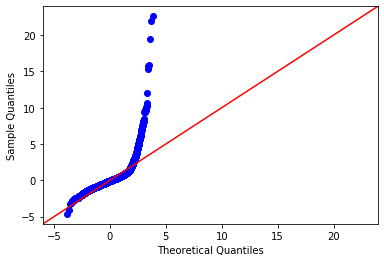

In [63]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);

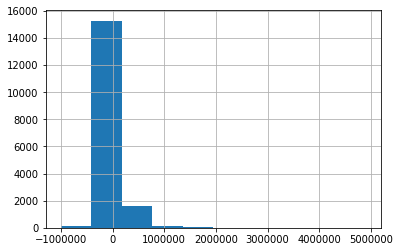

In [64]:
model_cont_features.resid.hist()

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


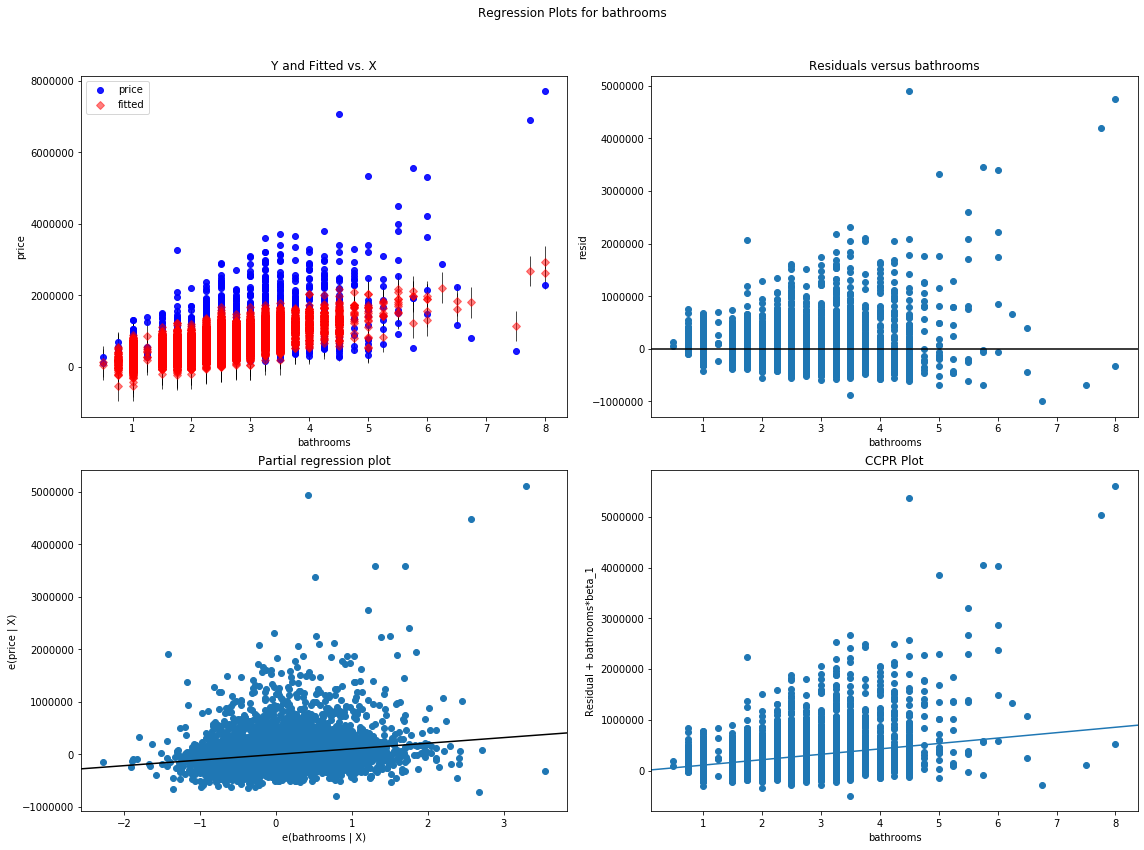

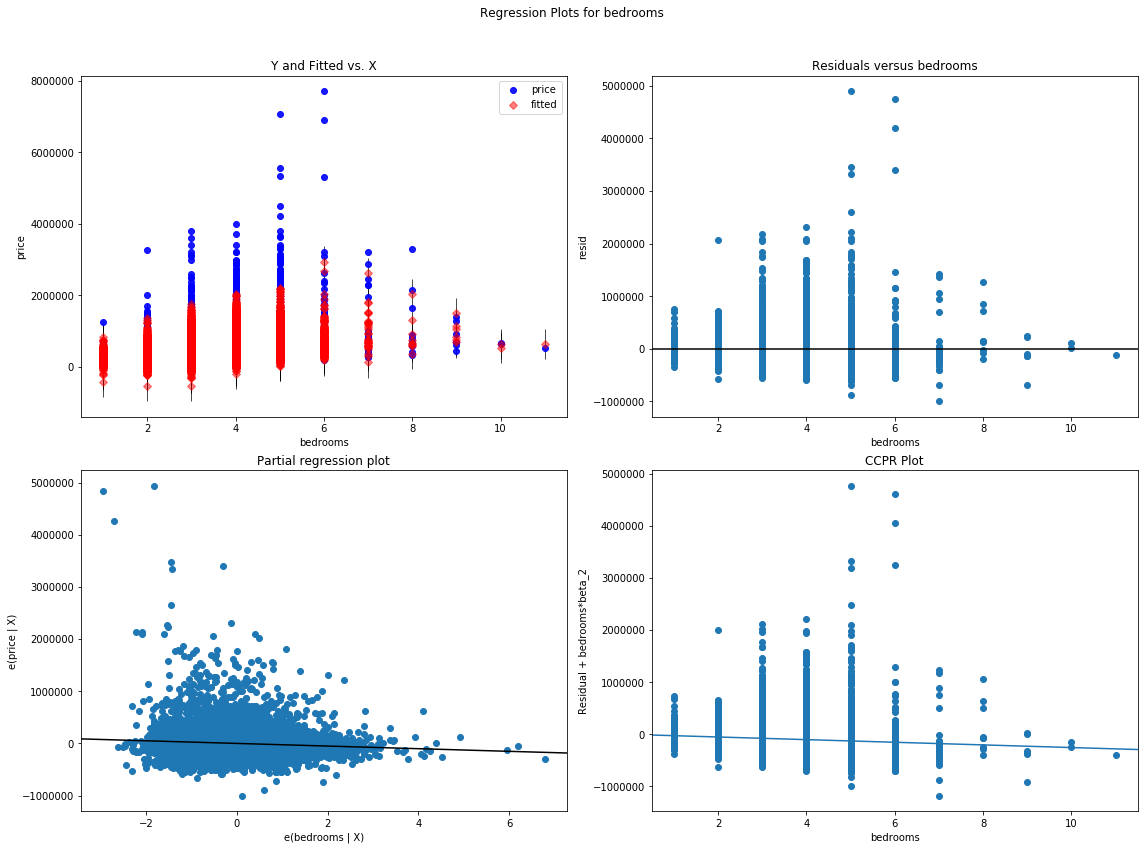

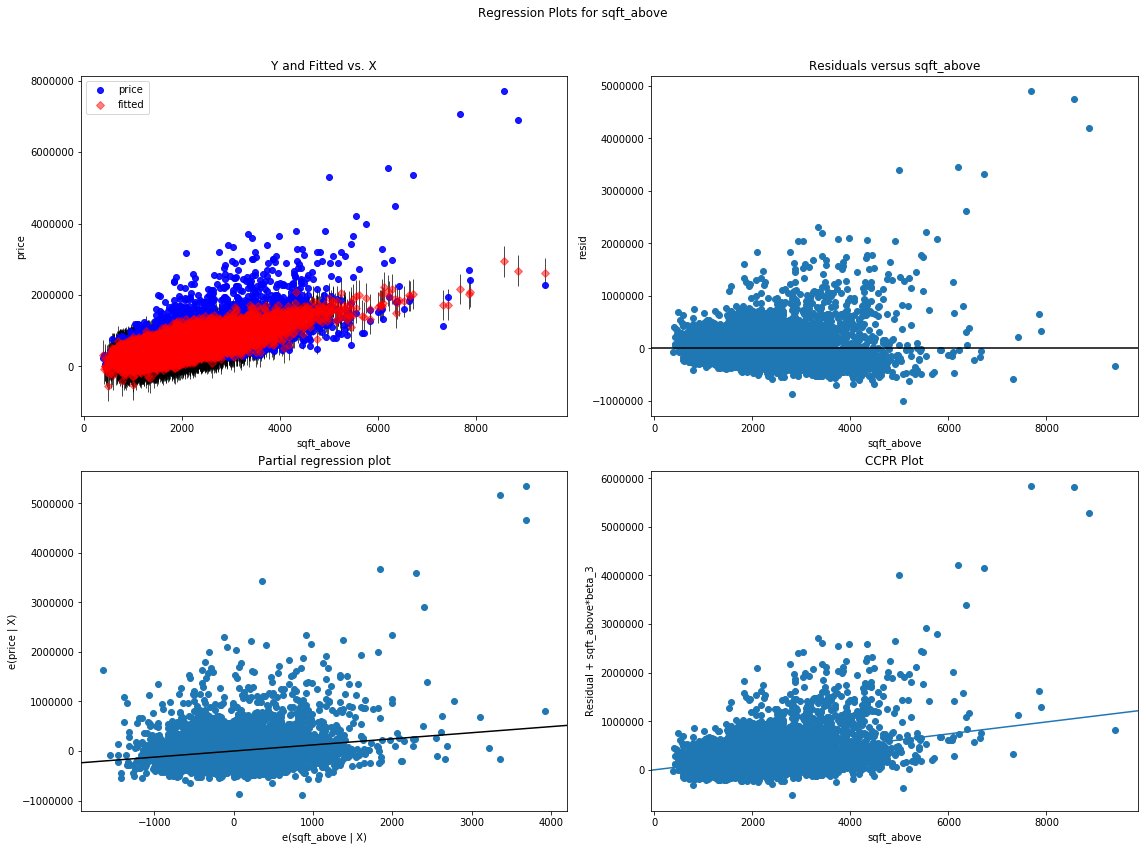

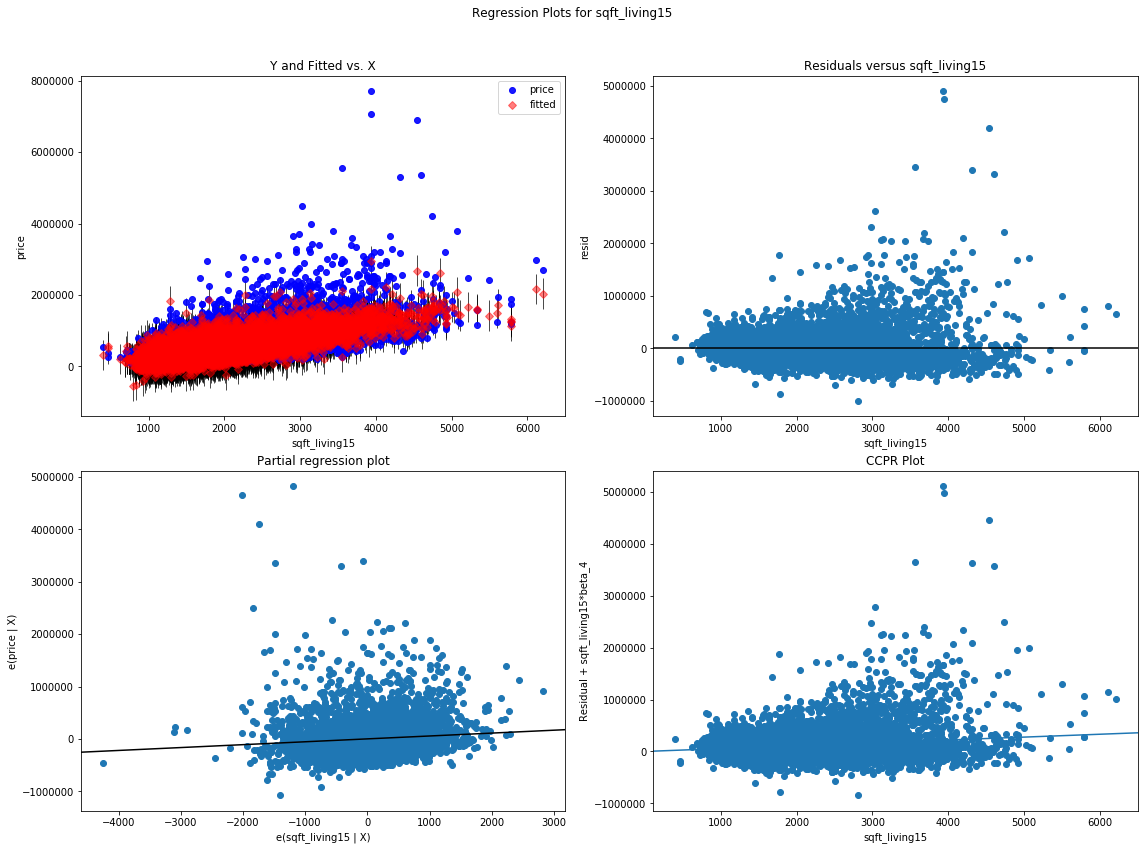

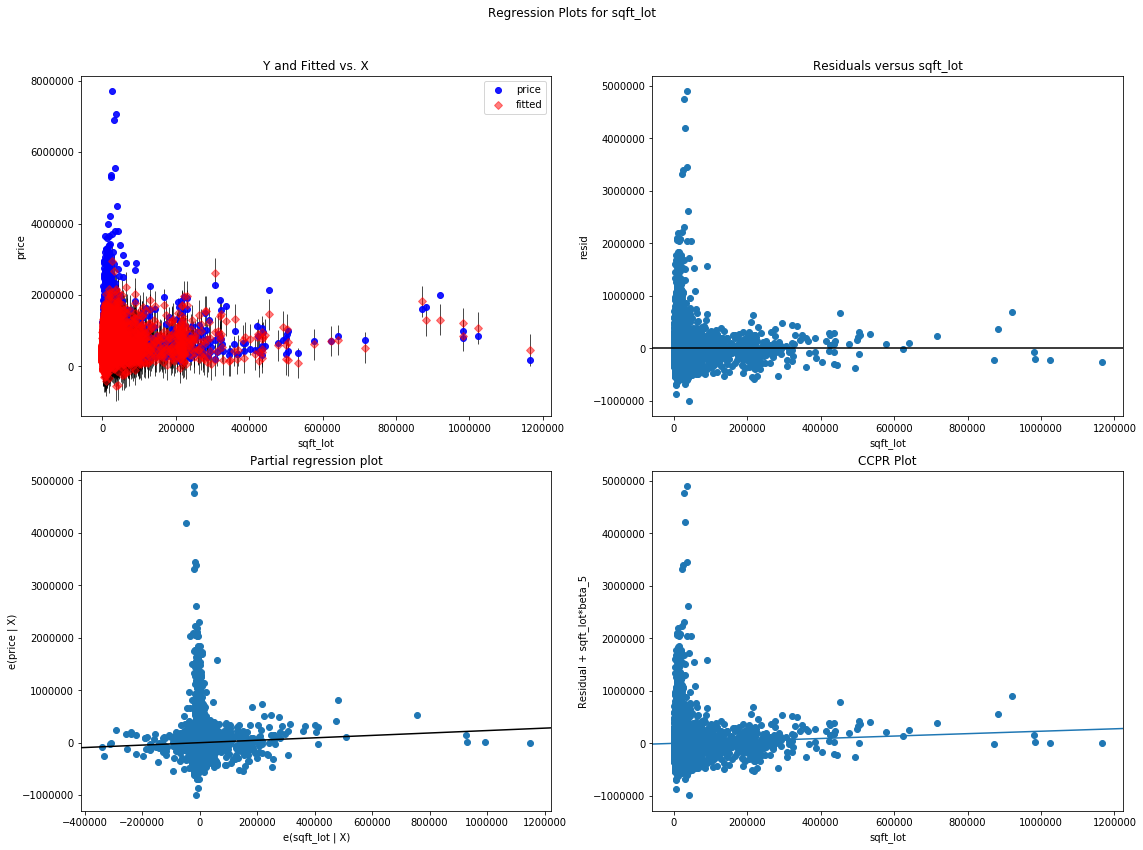

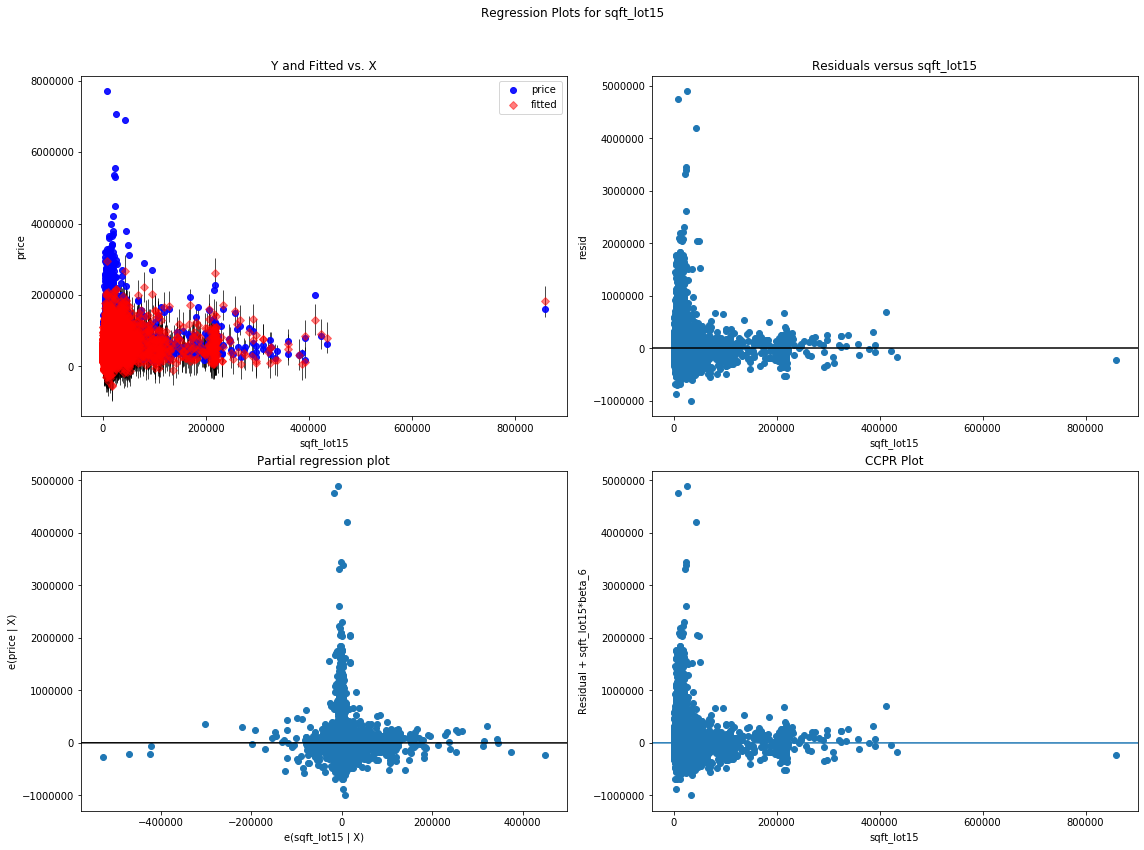

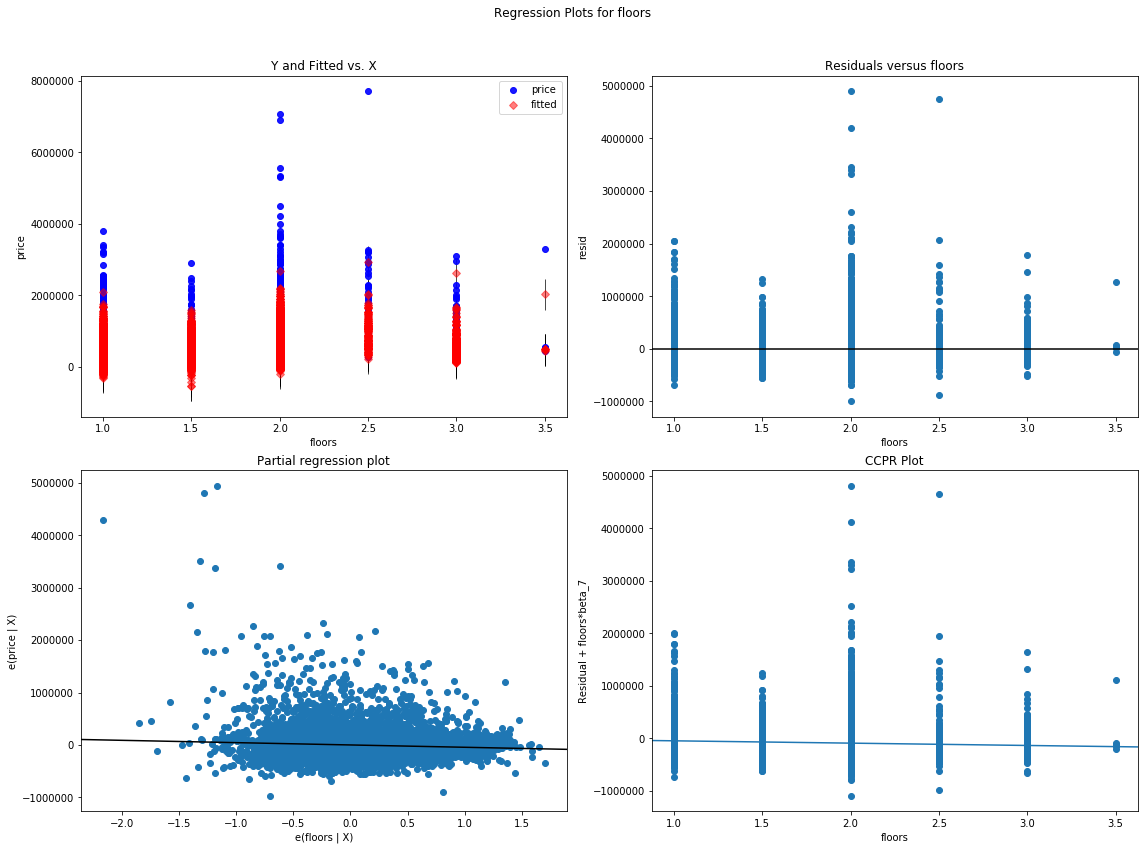

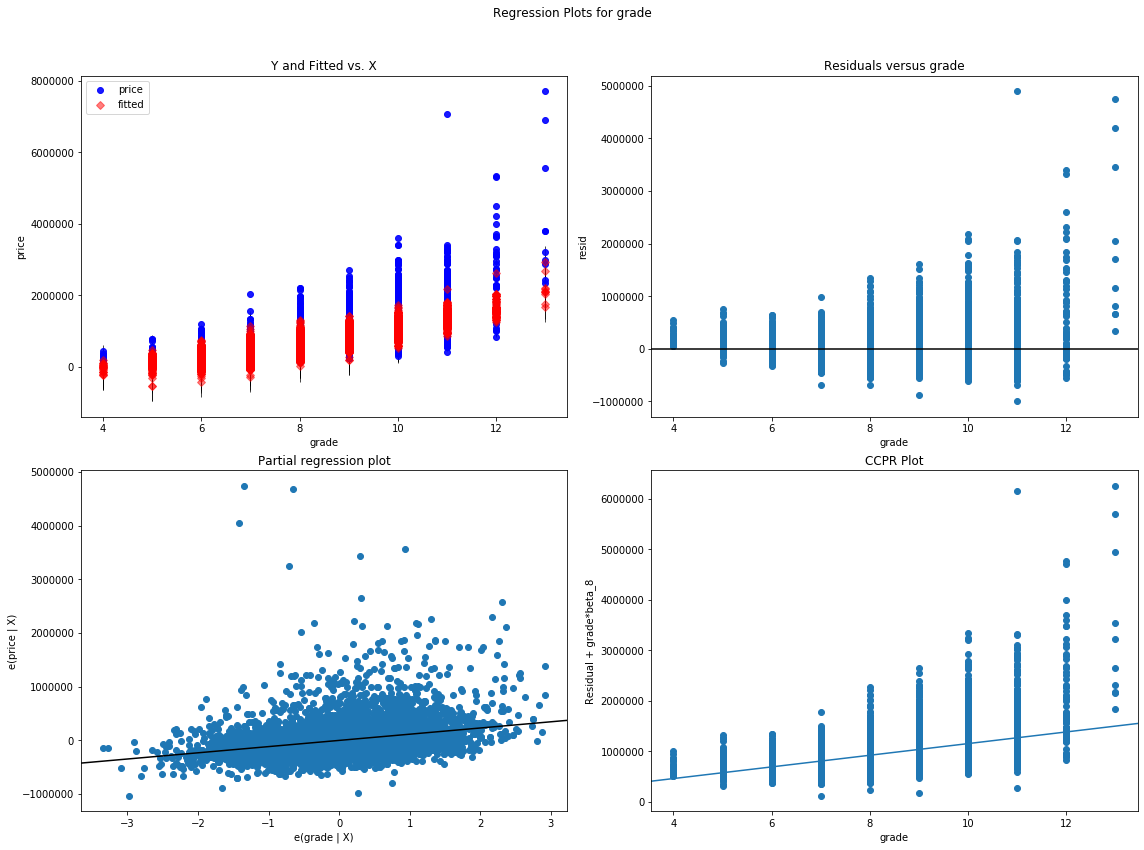

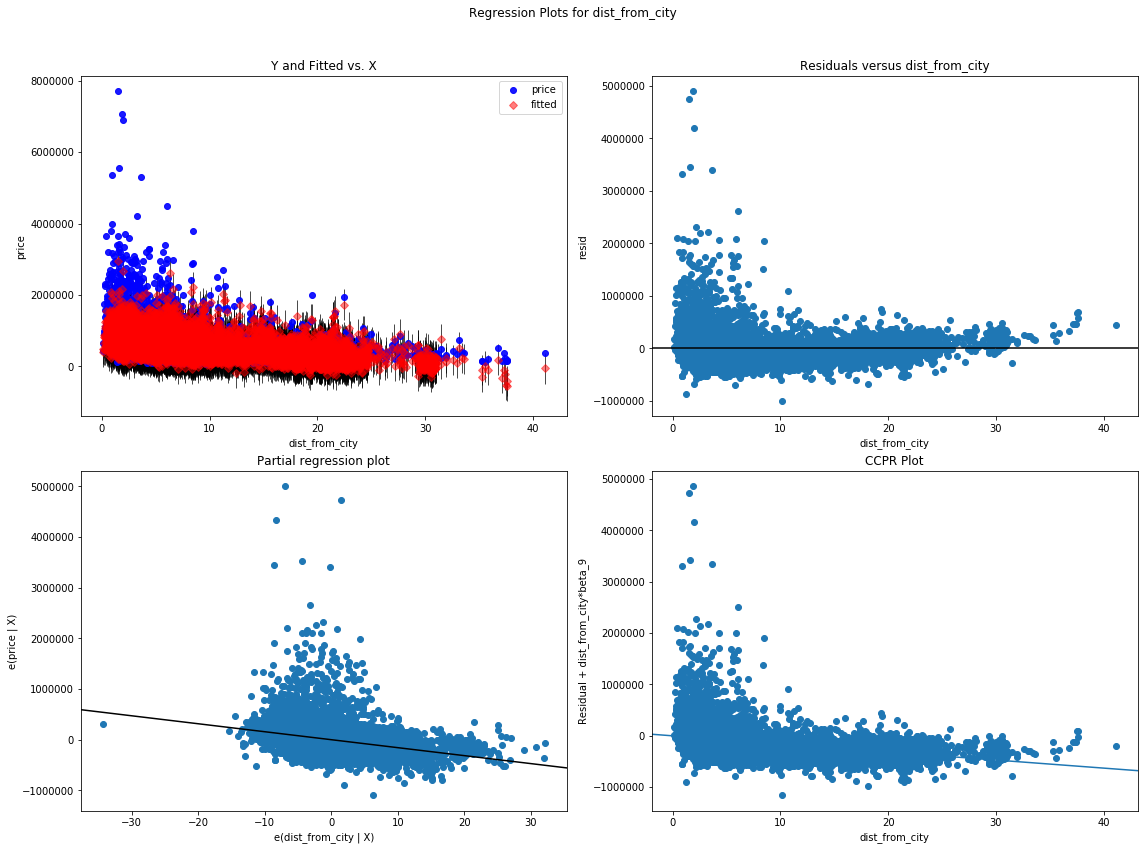

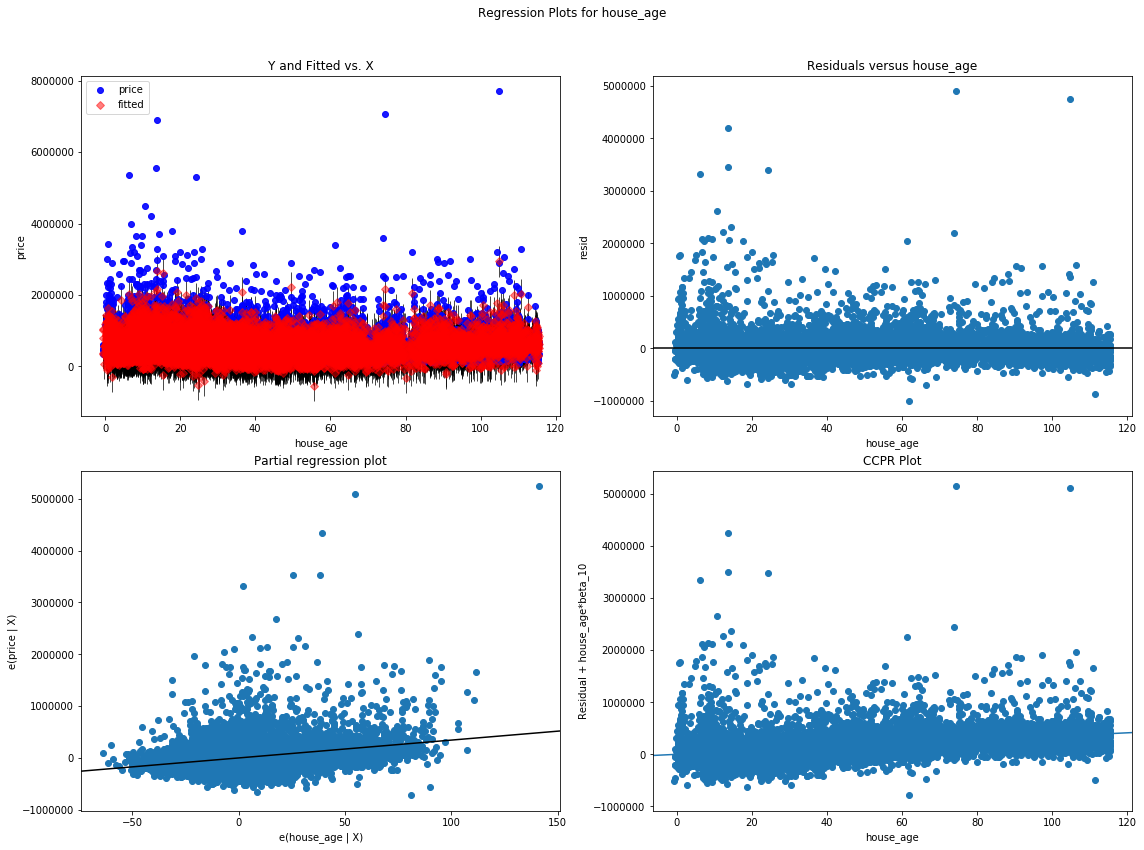

In [65]:
for col in X_train_cont_features.columns:
    fig = plt.figure(figsize=(16,12))
    sm.graphics.plot_regress_exog(model_cont_features, col, fig=fig)
    fig.show()

In [66]:
for i in range(len(X_train_cont_features.columns)):
    v=vif(np.matrix(X_train_cont_features),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features.columns[i],round(v,2)))

Variance inflation factor for bathrooms: 23.0
Variance inflation factor for bedrooms: 21.35
Variance inflation factor for sqft_above: 17.95
Variance inflation factor for sqft_living15: 24.87
Variance inflation factor for sqft_lot: 2.36
Variance inflation factor for sqft_lot15: 2.55
Variance inflation factor for floors: 13.77
Variance inflation factor for grade: 54.66
Variance inflation factor for dist_from_city: 2.76
Variance inflation factor for house_age: 3.96


In [67]:
X_train_cont_features.corr()

,bathrooms,bedrooms,sqft_above,sqft_living15,sqft_lot,sqft_lot15,floors,grade,dist_from_city,house_age
bathrooms,1.000000,0.532063,0.688910,0.569046,0.100348,0.091730,0.499065,0.666160,-0.028157,-0.509343
bedrooms,0.532063,1.000000,0.499119,0.407847,0.037266,0.033978,0.185782,0.370765,-0.005801,-0.169031
sqft_above,0.688910,0.499119,1.000000,0.731819,0.200206,0.198301,0.518443,0.755877,0.023473,-0.425652
sqft_living15,0.569046,0.407847,0.731819,1.000000,0.147943,0.181626,0.273876,0.712445,-0.053585,-0.329407
sqft_lot,0.100348,0.037266,0.200206,0.147943,1.000000,0.711521,-0.002144,0.125897,0.169266,-0.060650
sqft_lot15,0.091730,0.033978,0.198301,0.181626,0.711521,1.000000,-0.012872,0.118662,0.184512,-0.070169
floors,0.499065,0.185782,0.518443,0.273876,-0.002144,-0.012872,1.000000,0.454715,-0.041096,-0.492187
grade,0.666160,0.370765,0.755877,0.712445,0.125897,0.118662,0.454715,1.000000,-0.133004,-0.451177
dist_from_city,-0.028157,-0.005801,0.023473,-0.053585,0.169266,0.184512,-0.041096,-0.133004,1.000000,-0.222323
house_age,-0.509343,-0.169031,-0.425652,-0.329407,-0.060650,-0.070169,-0.492187,-0.451177,-0.222323,1.000000


### Summary

Baseline model

The residuals do not have a normal distribution, they are skewed to the right, and have heavy tails, as is shown in the q-q plot and the histogram.

From the Regression Plots we learned:

bathrooms
* correlated with target
* residuals are somewhat homoskedastic

bedrooms
* not correlated with target over all its values, only up to 5
* residuals are not homeskedastic

sqft_living
* correlated with target
* residuals are not homoskedastic.  They are close to the mean when the var is low and increase from there. **Might improve if the highest value is dropped.**

sqft_living15
* correlated with target
* residuals are somewhat homoskedastic.

sqft_lot
* not correlated with target
* residuals are not homoskedastic
* doesn't do well with small lot sizes and high prices, which would be urban settings, maybe an interaction would help

sqft_lot15
* not correlated with target
* residuals are not homoskedastic
* similar to sqft_lot

floors
* not well correlated with the target
* residuals are somewhat homoskedastic
* split levels and large 3+ floor houses cause problems.

grade
* correlated with the target
* residuals are not homoskedastic, they increase as grade increases.  May be a good candidate to be a polynomial feature

d_from_city
* negative correlation with the target, but not well for low values
* residuals are homoskedastic except for the low values

From the VIF report and the correlation report we can see that there are significant multicolinearity issues that need to be dealt with.  I will standardize the affected features and rerun the regression below.

Using a cutoff of 0.7 in the correlation matrix, the affected features are:
* bathrooms
* sqft_living
* grade
* sqft_living15

The VIF report also includes the following:
* floors
* bedrooms

Standardizing the features around 0 will maintain their interpretability while potentially dealing with the multicolinearity issues.

## Data Cleaning of Features in Simple Model

### Standardize the features with multicolinearity issues

In [68]:
m_cols = ['bathrooms', 'sqft_above', 'sqft_living15', 'grade', 'floors', 'bedrooms']
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_train[scaled_col_name] = scale(X_train[col], with_std=False)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a 

In [69]:
for col in m_cols:
    scaled_col_name = col+'_scaled'
    X_test[scaled_col_name] = scale(X_test[col], with_std=False)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages

## Rerun simple model

The simple model was rerun with the new standardizations several times to get the best R^2, RMSE and least multicolinearity issues.

In the baseline model, sqft_lot had a high p-value, but it performed better after the above standardizations, so it was kept.

Two features still showed multicolinearity problems so they were dropped:
* sqft_living_scaled
* floors_scaled

One feature ended up with a high p-value and was dropped
* bedrooms_scaled


### Define Feature Sets

In [70]:
cont_data_cols2 = ['bathrooms_scaled', 
                   #'bedrooms_scaled', 
                   'sqft_above_scaled', 
                   'sqft_living15_scaled', 
                   'sqft_lot', 
                   #'sqft_lot15', 
                   #'floors_scaled',
                   'grade_scaled',
                  'dist_from_city',
                  'house_age']

In [71]:
X_train_cont_features_rerun = X_train[cont_data_cols2]
X_test_cont_features_rerun = X_test[cont_data_cols2]

### Linear Regression sklearn

In [72]:
lin_reg_sklearn(X_train_cont_features_rerun, X_test_cont_features_rerun, y_train, y_test)

Training Set RMSE: 218029.34721828287
Test Set RMSE: 218356.77061011395

Training Set MAE: 131385.96488025424
Test Set MAE: 130572.42846061847

Cross Val RMSE: 218375.3562652321


### Linear Regression statsmodels

In [73]:
X_train.sqft_above.describe()

count    17134.000000
mean      1792.882923
std        831.356415
min        390.000000
25%       1200.000000
50%       1560.000000
75%       2220.000000
max       9410.000000
Name: sqft_above, dtype: float64

In [74]:
X_train.sqft_above_scaled.describe()

count    1.713400e+04
mean     1.460797e-13
std      8.313564e+02
min     -1.402883e+03
25%     -5.928829e+02
50%     -2.328829e+02
75%      4.271171e+02
max      7.617117e+03
Name: sqft_above_scaled, dtype: float64

In [75]:
model_cont_features = lin_reg_statsmodels(X_train_cont_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     4482.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:12:33   Log-Likelihood:            -2.3493e+05
No. Observations:               17134   AIC:                         4.699e+05
Df Residuals:                   17126   BIC:                         4.699e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.138e+05   4753.311    108.088      0.000    5.04e+05    5.23e+05
bathrooms_scaled      8.886e+04   3280.278     27.090      0.000    8.24e+04    9.53e+04
sqft_above_scaled      101.0367      3.667     27.553      0.000      93.849     108.224
sqft_living15_scaled    62.6941      3.811     16.450      0.000      55.224      70.165
sqft_lot                 0.3108      0.044      7.097      0.000       0.225       0.397
grade_scaled          1.169e+05   2529.353     46.208      0.000    1.12e+05    1.22e+05
dist_from_city       -1.542e+04    281.724    -54.731      0.000    -1.6e+04   -1.49e+04
house_age             3574.9751     70.519     50.695      0.000    3436.750    3713.200
==============================================================================
Omnibus:                    18028.760   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3216353.490
Skew:                           4.938   Prob(JB):                         0.00
Kurtosis:                      69.390   Cond. No.                     1.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check for Multicolinearity

In [76]:
for i in range(len(X_train_cont_features_rerun.columns)):
    v=vif(np.matrix(X_train_cont_features_rerun),i)
    print("Variance inflation factor for {}: {}".format(X_train_cont_features_rerun.columns[i],round(v,2)))

Variance inflation factor for bathrooms_scaled: 2.18
Variance inflation factor for sqft_above_scaled: 3.32
Variance inflation factor for sqft_living15_scaled: 2.48
Variance inflation factor for sqft_lot: 1.23
Variance inflation factor for grade_scaled: 2.95
Variance inflation factor for dist_from_city: 1.74
Variance inflation factor for house_age: 1.78


In [77]:
X_train_cont_features_rerun.corr()

,bathrooms_scaled,sqft_above_scaled,sqft_living15_scaled,sqft_lot,grade_scaled,dist_from_city,house_age
bathrooms_scaled,1.000000,0.688910,0.569046,0.100348,0.666160,-0.028157,-0.509343
sqft_above_scaled,0.688910,1.000000,0.731819,0.200206,0.755877,0.023473,-0.425652
sqft_living15_scaled,0.569046,0.731819,1.000000,0.147943,0.712445,-0.053585,-0.329407
sqft_lot,0.100348,0.200206,0.147943,1.000000,0.125897,0.169266,-0.060650
grade_scaled,0.666160,0.755877,0.712445,0.125897,1.000000,-0.133004,-0.451177
dist_from_city,-0.028157,0.023473,-0.053585,0.169266,-0.133004,1.000000,-0.222323
house_age,-0.509343,-0.425652,-0.329407,-0.060650,-0.451177,-0.222323,1.000000


### Regression Plots

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


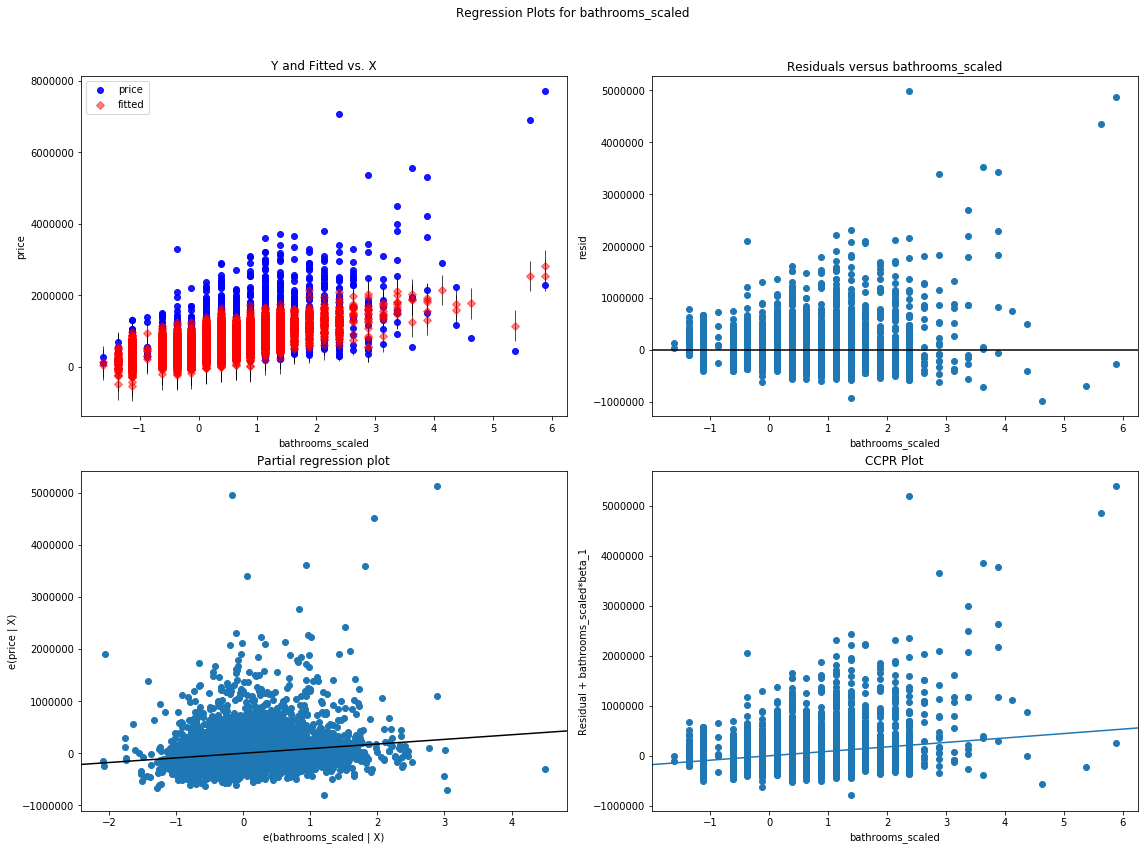

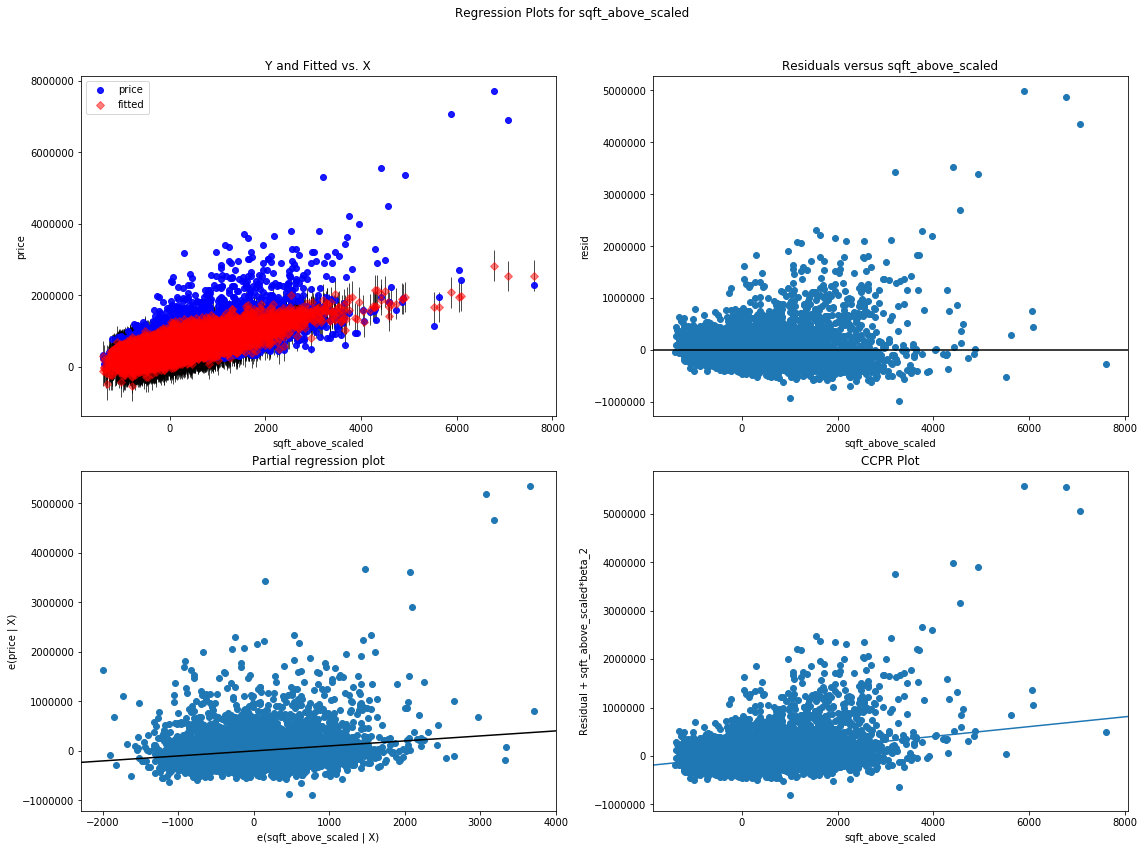

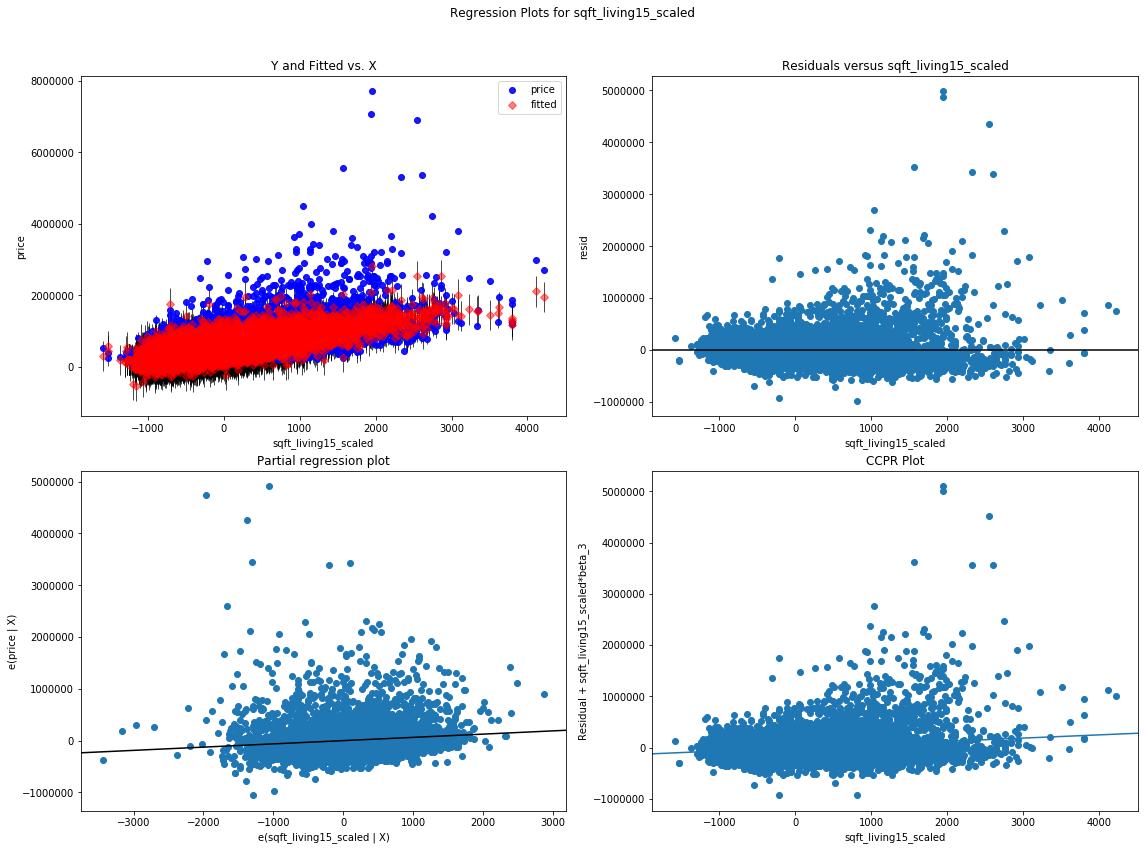

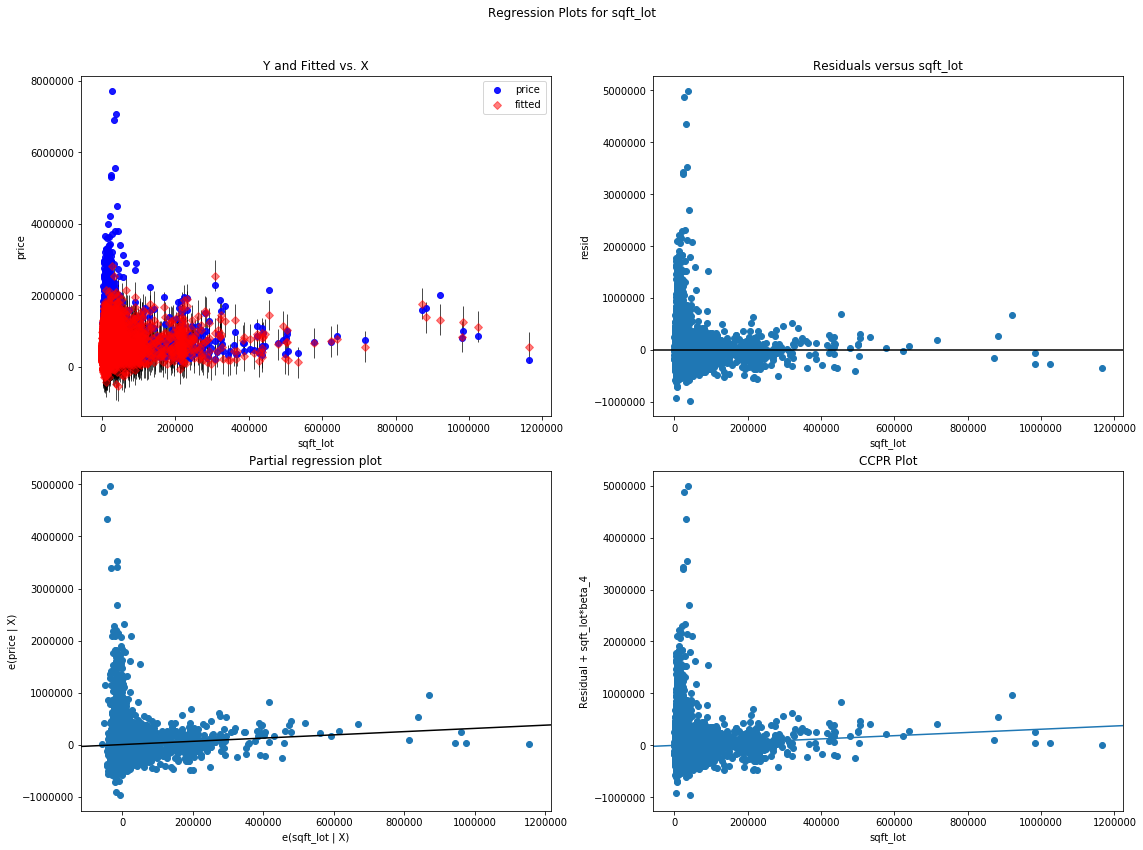

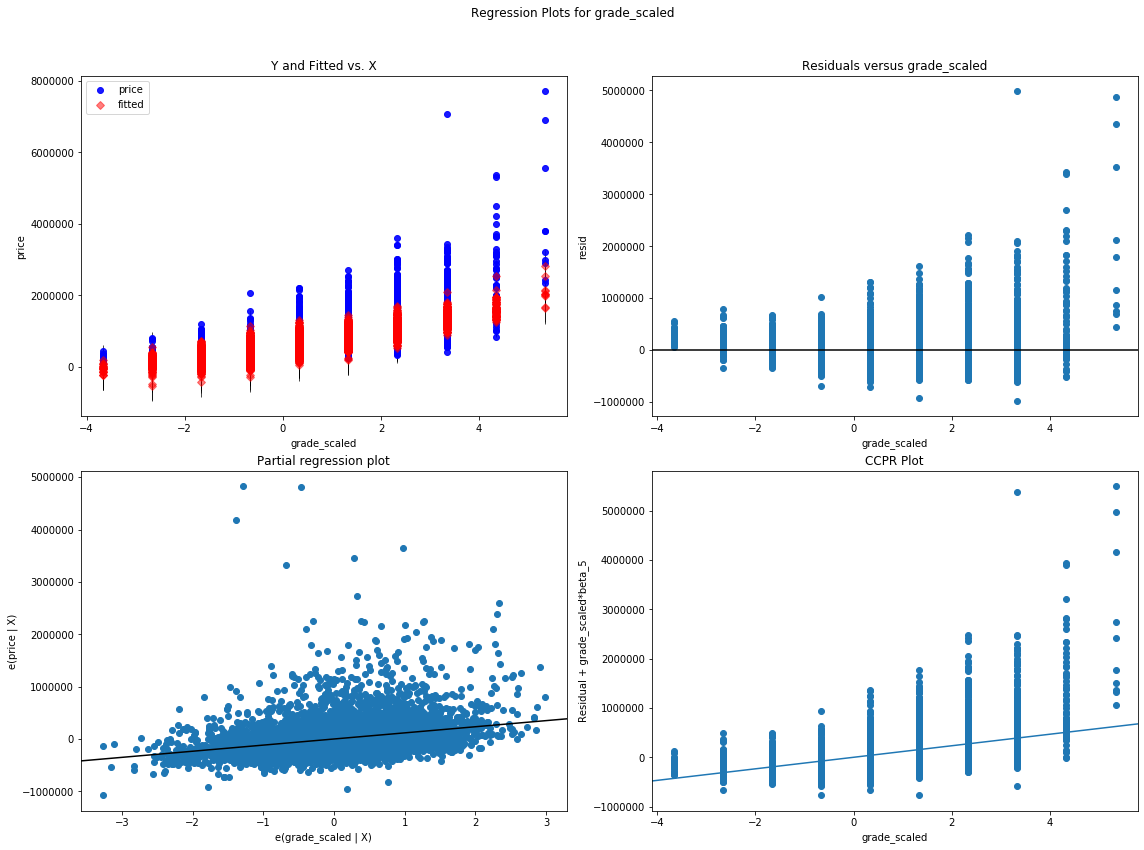

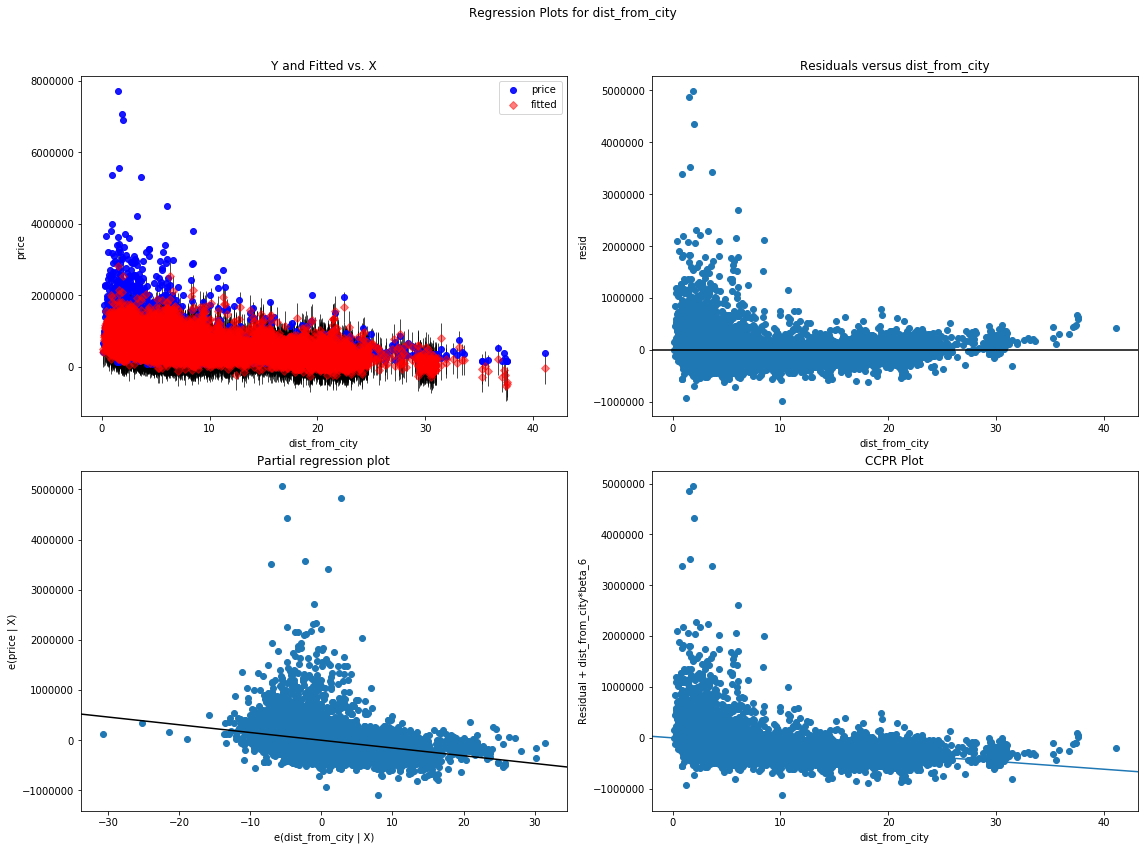

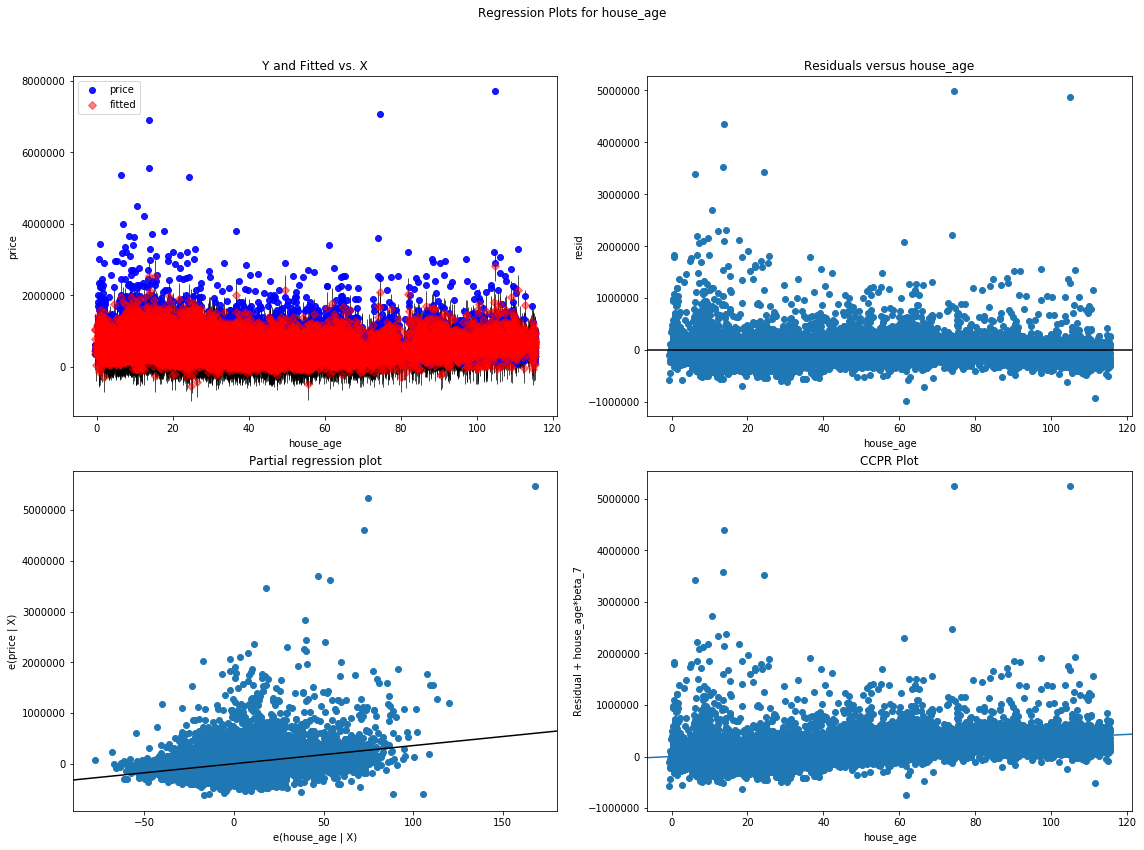

In [78]:
regression_plots(X_train_cont_features_rerun, model_cont_features)

### Summary

Removing the largest outlier in sqft_living improved the correlation of sqft_above to the target, but only had marginal improvement to the model.

The standardizations reduced the multicolinearity of the model, but not all of it.  Multiple features were removed to make the interpretation of the remaining features better, but the model's performance stats, R^2 and RMSE got worse.  Despite the worse stats, the coefficients should be more trustworthy and there are more features that can be interpreted.

## Simple Model + Categoricals

This model will contain all the continuous variables and the categorical variables.  The continuous variables that were removed above will be put back into the feature list for the initial run of this model.

### Define Feature Sets

Because there are no so many features, I will specify which to ignore instead of which to include.

In [79]:
for col in X_train.columns:
    print(col)

id
date
bedrooms
bathrooms
sqft_living
sqft_lot
floors
grade
sqft_above
sqft_basement
yr_built
yr_renovated
lat
long
sqft_living15
sqft_lot15
dist_from_city
house_age
view__1
view__2
view__3
view__4
waterfront__1
had_reno__1
yr_updated_(1954.0, 1977.0]
yr_updated_(1977.0, 1999.0]
yr_updated_(1999.0, 2015.0]
condition_2
condition_3
condition_4
condition_5
_98002
_98003
_98004
_98005
_98006
_98007
_98008
_98010
_98011
_98014
_98019
_98022
_98023
_98024
_98027
_98028
_98029
_98030
_98031
_98032
_98033
_98034
_98038
_98039
_98040
_98042
_98045
_98052
_98053
_98055
_98056
_98058
_98059
_98065
_98070
_98072
_98074
_98075
_98077
_98092
_98102
_98103
_98105
_98106
_98107
_98108
_98109
_98112
_98115
_98116
_98117
_98118
_98119
_98122
_98125
_98126
_98133
_98136
_98144
_98146
_98148
_98155
_98166
_98168
_98177
_98178
_98188
_98198
_98199
season__1
season__2
new_build__1
split_level__1
has_basement__1
urban__1
bathrooms_scaled
sqft_above_scaled
sqft_living15_scaled
grade_scaled
floors_scaled
bedr

In [80]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
ssc_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
ssc_cols = sorted(ssc_cols)

X_train_ssc_features = X_train[ssc_cols]
X_test_ssc_features = X_test[ssc_cols]

### Linear Regression sklearn

In [81]:
lin_reg_sklearn(X_train_ssc_features, X_test_ssc_features, y_train, y_test)

Training Set RMSE: 162954.93537730924
Test Set RMSE: 162561.96484595284

Training Set MAE: 95692.21214606163
Test Set MAE: 95578.64731177519

Cross Val RMSE: 165144.75506094206


### Linear Regression Statsmodels

In [82]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     707.4
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:12:51   Log-Likelihood:            -2.2994e+05
No. Observations:               17134   AIC:                         4.601e+05
Df Residuals:                   17035   BIC:                         4.608e+05
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        3.927e+05   4.48e+04      8.774      0.000    3.05e+05     4.8e+05
_98002                       2.465e+04   1.62e+04      1.525      0.127   -7037.756    5.63e+04
_98003                      -1.574e+04   1.47e+04     -1.072      0.284   -4.45e+04     1.3e+04
_98004                       6.243e+05   2.36e+04     26.494      0.000    5.78e+05     6.7e+05
_98005                       1.348e+05   2.46e+04      5.469      0.000    8.65e+04    1.83e+05
_98006                       1.431e+05      2e+04      7.138      0.000    1.04e+05    1.82e+05
_98007                       9.891e+04   2.54e+04      3.889      0.000    4.91e+04    1.49e+05
_98008                        1.02e+05    2.2e+04      4.635      0.000    5.89e+04    1.45e+05
_98010                       6.715e+04   2.11e+04      3.183      0.001    2.58e+04    1.09e+05
_98011                      -8792.9364   2.23e+04     -0.394      0.693   -5.25e+04    3.49e+04
_98014                       4.139e+04    2.1e+04      1.970      0.049     204.060    8.26e+04
_98019                       -1.18e+04   2.05e+04     -0.576      0.564   -5.19e+04    2.83e+04
_98022                        4.28e+04   1.78e+04      2.408      0.016    7965.382    7.76e+04
_98023                      -2.405e+04   1.27e+04     -1.891      0.059    -4.9e+04     877.481
_98024                       8.933e+04   2.53e+04      3.531      0.000    3.97e+04    1.39e+05
_98027                       8.457e+04   1.73e+04      4.890      0.000    5.07e+04    1.18e+05
_98028                      -6765.5055   2.07e+04     -0.326      0.744   -4.74e+04    3.39e+04
_98029                       1.189e+05   1.83e+04      6.516      0.000    8.32e+04    1.55e+05
_98030                      -2.943e+04   1.52e+04     -1.936      0.053   -5.92e+04     365.523
_98031                      -3.459e+04   1.61e+04     -2.155      0.031    -6.6e+04   -3124.722
_98032                      -1.938e+04   1.95e+04     -0.995      0.320   -5.76e+04    1.88e+04
_98033                       1.905e+05   2.28e+04      8.367      0.000    1.46e+05    2.35e+05
_98034                       5.337e+04    2.1e+04      2.542      0.011    1.22e+04    9.45e+04
_98038                       1.099e+04   1.25e+04      0.880      0.379   -1.35e+04    3.55e+04
_98039                       1.258e+06   3.36e+04     37.413      0.000    1.19e+06    1.32e+06
_98040                       3.711e+05   2.19e+04     16.938      0.000    3.28e+05    4.14e+05
_98042                      -2.324e+04   1.28e+04     -1.809      0.070   -4.84e+04    1939.400
_98045                       9.464e+04   1.58e+04      5.979      0.000    6.36e+04    1.26e+05
_98052                       6.356e+04    2.2e+04      2.894      0.004    2.05e+04    1.07e+05
_98053     

### Check for Multicolinearity

In [83]:
vif_analysis(X_train_ssc_features)

Variance inflation factor for _98002: 1.54
Variance inflation factor for _98003: 1.73
Variance inflation factor for _98004: 4.06
Variance inflation factor for _98005: 2.6
Variance inflation factor for _98006: 4.75
Variance inflation factor for _98007: 2.14
Variance inflation factor for _98008: 3.34
Variance inflation factor for _98010: 1.27
Variance inflation factor for _98011: 2.29
Variance inflation factor for _98014: 1.49
Variance inflation factor for _98019: 2.01
Variance inflation factor for _98022: 2.18
Variance inflation factor for _98023: 2.32
Variance inflation factor for _98024: 1.29
Variance inflation factor for _98027: 2.93
Variance inflation factor for _98028: 2.94
Variance inflation factor for _98029: 2.56
Variance inflation factor for _98030: 1.76
Variance inflation factor for _98031: 1.87
Variance inflation factor for _98032: 1.37
Variance inflation factor for _98033: 5.16
Variance inflation factor for _98034: 5.61
Variance inflation factor for _98038: 2.58
Variance inf

### Analyze the Residuals

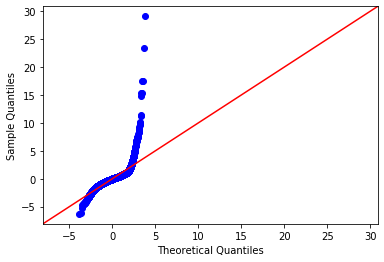

In [84]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

The yr_updated features don't make sense, a base value of the oldest houses shouldn't be the most expensive house, so they also will be removed.

In [85]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 'yr_updated_(1954.0, 1977.0]',
         'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]', 'dist_from_city']

X_train_cols = [col for col in X_train_ssc_features.columns if col not in m_cols]

In [86]:
if run_stepwise_selection:
    BidirectionalStepwiseSelection(X_train_ssc_features[X_train_cols], 
                                   y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : view__4 	AIC : 486145.1699108254
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 478352.182763612
break : No need to Backward Elimination
Entered : has_basement__1 	AIC : 475713.45835621044
break : No need to Backward Elimination
Entered : _98004 	AIC : 474099.8991835611
break : No need to Backward Elimination
Entered : grade_scaled 	AIC : 472395.2270318572
break : No need to Backward Elimination
Entered : house_age 	AIC : 469753.98269664746
break : No need to Backward Elimination
Entered : urban__1 	AIC : 467711.19642591366
break : No need to Backward Elimination
Entered : _98039 	AIC : 466498.5428700033
break : No need to Backward Elimination
Entered : waterfront__1 	AIC : 465911.706291656
break : No need to Backward Elimination
Entered : _98040 	AIC : 465396.7491431553
break : No need to Backward Elimination
Entered : _98112 	AIC : 465048.99

### Summary

The R^2 and RMSE stats saw a significant improvement over the baseline model.

Some of the features that were dropped from the baseline model were found to be significant here.

There still seemed to be some multicolinearity issues with floors_scaled and bedrooms_scaled.

There were quite a few of the categorical features that had high p-values.  A stepwise selection was run to find out a potentially better feature set.

## Rerun the Simple + Categoricals Model

The simple + categoricals model will be rerun with the feature set chosen by stepwise selection.

### Define Features

In [87]:
# columns chosen by stepwise selection
cols_to_include = ['view__4', 'sqft_above_scaled', 'grade_scaled', '_98004', 'urban__1', 'house_age', '_98039', 'has_basement__1', 'waterfront__1', '_98040', '_98112', 'view__3', '_98117', '_98023', 'bathrooms_scaled', '_98033', '_98103', 'view__2', '_98105', '_98092', '_98115', '_98006', '_98119', '_98199', '_98102', '_98109', 'condition_5', '_98042', '_98003', '_98107', 'view__1', '_98029', '_98177', '_98198', '_98030', '_98058', '_98022', '_98038', '_98031', 'sqft_lot', 'sqft_living15_scaled', '_98122', '_98070', 'condition_4', '_98136', '_98032', '_98002', '_98178', 'season__1', '_98005', '_98116', '_98144', '_98125', '_98053', '_98008', '_98052', '_98133', '_98027', '_98126', '_98034', '_98007', '_98118', '_98075', '_98155', '_98074', '_98072', '_98106', 'had_reno__1', 'new_build__1', 'split_level__1', '_98024', '_98077', '_98028', '_98056']

In [88]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [89]:
X_train_ssc_features_rerun = X_train[cols_to_include]
X_test_ssc_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [90]:
lin_reg_sklearn(X_train_ssc_features_rerun, X_test_ssc_features_rerun, y_train, y_test)

Training Set RMSE: 165720.7164931978
Test Set RMSE: 167262.47344409922

Training Set MAE: 97367.32191731574
Test Set MAE: 98401.9664233749

Cross Val RMSE: 167684.18385432597


### Linear Regression Statsmodels

In [91]:
model_ssc_features = lin_reg_statsmodels(X_train_ssc_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     899.4
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:16:09   Log-Likelihood:            -2.3023e+05
No. Observations:               17134   AIC:                         4.606e+05
Df Residuals:                   17059   BIC:                         4.612e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.851e+05   6745.846     42.263      0.000    2.72e+05    2.98e+05
_98002               -4.605e+04   1.36e+04     -3.386      0.001   -7.27e+04   -1.94e+04
_98003               -8.456e+04   1.17e+04     -7.236      0.000   -1.07e+05   -6.17e+04
_98004                7.014e+05   1.21e+04     58.089      0.000    6.78e+05    7.25e+05
_98005                1.923e+05   1.53e+04     12.595      0.000    1.62e+05    2.22e+05
_98006                 1.84e+05   9487.506     19.398      0.000    1.65e+05    2.03e+05
_98007                1.399e+05   1.73e+04      8.112      0.000    1.06e+05    1.74e+05
_98008                1.436e+05   1.24e+04     11.621      0.000    1.19e+05    1.68e+05
_98022               -9.151e+04   1.28e+04     -7.172      0.000   -1.17e+05   -6.65e+04
_98023               -9.706e+04   9016.056    -10.765      0.000   -1.15e+05   -7.94e+04
_98024                8.058e+04   2.24e+04      3.594      0.000    3.66e+04    1.25e+05
_98027                9.523e+04   9943.736      9.577      0.000    7.57e+04    1.15e+05
_98028                3.397e+04   1.16e+04      2.936      0.003    1.13e+04    5.67e+04
_98029                1.294e+05   1.12e+04     11.598      0.000    1.08e+05    1.51e+05
_98030               -7.012e+04   1.17e+04     -5.984      0.000   -9.31e+04   -4.72e+04
_98031               -6.131e+04   1.18e+04     -5.200      0.000   -8.44e+04   -3.82e+04
_98032               -6.332e+04   1.69e+04     -3.749      0.000   -9.64e+04   -3.02e+04
_98033                2.586e+05   1.06e+04     24.450      0.000    2.38e+05    2.79e+05
_98034                1.035e+05   9668.494     10.705      0.000    8.46e+04    1.22e+05
_98038               -4.099e+04   8387.334     -4.887      0.000   -5.74e+04   -2.45e+04
_98039                1.349e+06   2.75e+04     49.130      0.000    1.29e+06     1.4e+06
_98040                4.156e+05   1.23e+04     33.858      0.000    3.92e+05     4.4e+05
_98042               -6.843e+04   8653.460     -7.907      0.000   -8.54e+04   -5.15e+04
_98052                1.232e+05   9684.249     12.724      0.000    1.04e+05    1.42e+05
_98053                1.163e+05   1.02e+04     11.380      0.000    9.62e+04    1.36e+05
_98056                2.894e+04   9786.183      2.957      0.003    9760.455    4.81e+04
_98058               -4.578e+04   9138.133     -5.010      0.000   -6.37e+04   -2.79e+04
_98070               -9.498e+04   1.84e+04     -5.170      0.000   -1.31e+05    -5.9e+04
_98072                7.426e+04   1.17e+04      6.338      0.000    5.13e+04    9.72e+04
_98074                7.857e+04   9960.585      7.888      0.000     5.9e+04    9.81e+04
_98075                8.468e+04   1.07e+04      7.909      0.000    6.37e+04    1.06e+05
_98077                4.068e+04   1.37e+04      2.966    

### Check for Multicolinearity

In [92]:
vif_analysis(X_train_ssc_features_rerun)

Variance inflation factor for _98002: 1.06
Variance inflation factor for _98003: 1.07
Variance inflation factor for _98004: 1.31
Variance inflation factor for _98005: 1.17
Variance inflation factor for _98006: 1.3
Variance inflation factor for _98007: 1.12
Variance inflation factor for _98008: 1.25
Variance inflation factor for _98022: 1.08
Variance inflation factor for _98023: 1.12
Variance inflation factor for _98024: 1.04
Variance inflation factor for _98027: 1.11
Variance inflation factor for _98028: 1.09
Variance inflation factor for _98029: 1.09
Variance inflation factor for _98030: 1.06
Variance inflation factor for _98031: 1.07
Variance inflation factor for _98032: 1.03
Variance inflation factor for _98033: 1.37
Variance inflation factor for _98034: 1.45
Variance inflation factor for _98038: 1.14
Variance inflation factor for _98039: 1.07
Variance inflation factor for _98040: 1.22
Variance inflation factor for _98042: 1.14
Variance inflation factor for _98052: 1.48
Variance inf

### Analyze the Residuals

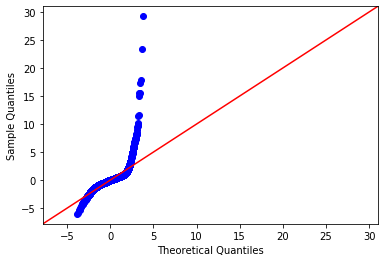

In [93]:
sm.graphics.qqplot(model_ssc_features.resid, line='45', fit=True);

### Summary

The re-run of the simple plus categoricals model did not change the R^2 and RMSE much, they in fact got a little worse, which is often the case when features are dropped, even if they are not significant.

However, the re-run with its feature set is the best model so far.

## Add Interaction Features

### sq_lot / sq_lot15

The size of the house lot as compared to its neighbors

In [94]:
X_train['lot*lot15'] = X_train.sqft_lot * X_train.sqft_lot15
X_test['lot*lot15'] = X_test.sqft_lot * X_test.sqft_lot15

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bathroom* bedroom

Home buyers often want enough bathrooms for the bedrooms in a house.

In [95]:
X_train['bathrooms_scaled*bedrooms_scaled'] = X_train.bathrooms_scaled * X_train.bedrooms_scaled
X_test['bathrooms_scaled*bedrooms_scaled'] = X_test.bathrooms_scaled * X_test.bedrooms_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_above * floors

How the living space is split up among the floors

In [96]:
X_train['sqft_above_scaled*floors_scaled'] = X_train.sqft_above_scaled * X_train.floors_scaled
X_test['sqft_above_scaled*floors_scaled'] = X_test.sqft_above_scaled * X_test.floors_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_living * sqft_living15

How the living space compares to its neighbors

In [97]:
X_train['sqft_above_scaled*sqft_living15_scaled'] = X_train.sqft_above_scaled * X_train.sqft_living15_scaled
X_test['sqft_above_scaled*sqft_living15_scaled'] = X_test.sqft_above_scaled * X_test.sqft_living15_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_above * sqft_lot

How the house fits on the property

In [98]:
X_train['sqft_above_scaled*sqft_lot'] = X_train.sqft_above_scaled * X_train.sqft_lot
X_test['sqft_above_scaled*sqft_lot'] = X_test.sqft_above_scaled * X_test.sqft_lot

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bedrooms * grade

In [99]:
X_train['bedrooms*grade'] = X_train.bedrooms * X_train.grade
X_test['bedrooms*grade'] = X_test.bedrooms * X_test.grade

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_above * grade

In [100]:
X_train['sqft_above_scaled*grade'] = X_train.sqft_above_scaled * X_train.grade
X_test['sqft_above_scaled*grade'] = X_test.sqft_above_scaled * X_test.grade

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### sqft_above * bedrooms

How big are the bedrooms?

In [101]:
X_train['sqft_above_scaled*bedrooms_scaled'] = X_train.sqft_above_scaled * X_train.bedrooms_scaled
X_test['sqft_above_scaled*bedrooms_scaled'] = X_test.sqft_above_scaled * X_test.bedrooms_scaled

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### season_1*waterfront_1

In [102]:
X_train['season__1*waterfront__1'] = X_train.season__1 * X_train.waterfront__1
X_test['season__1*waterfront__1'] = X_test.season__1 * X_test.waterfront__1

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### dist_from_city*waterfront_1

In [103]:
X_train['dist_from_city*waterfront__1'] = X_train.dist_from_city * X_train.waterfront__1
X_test['dist_from_city*waterfront__1'] = X_test.dist_from_city * X_test.waterfront__1

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### floors*split_level__1

In [104]:
X_train['floors_scaled*split_level__1'] = X_train.floors_scaled * X_train.split_level__1
X_test['floors_scaled*split_level__1'] = X_test.floors_scaled * X_test.split_level__1

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### had_reno*year_updated Bins

In [105]:
year_bins = ['yr_updated_(1977.0, 1999.0]', 'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1999.0, 2015.0]']
for year in year_bins:
    col_name = 'had_reno*'+year
    X_train[col_name] = X_train.had_reno__1 * X_train[year]
    X_test[col_name] = X_test.had_reno__1 * X_test[year]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Model With Interactions

This model will run with all the continuous and categorical features, plus the new interaction features.

### Define Feature Sets

In [106]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
int_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
int_cols = sorted(int_cols)

X_train_int_features = X_train[int_cols]
X_test_int_features = X_test[int_cols]

### Linear Regression sklearn

In [107]:
lin_reg_sklearn(X_train_int_features, X_test_int_features, y_train, y_test)

Training Set RMSE: 147883.3049229553
Test Set RMSE: 145954.4520434992

Training Set MAE: 88075.94820626348
Test Set MAE: 87464.78552779938

Cross Val RMSE: 150922.42797646625


### Linear Regression statsmodels

In [108]:
model_int_features = lin_reg_statsmodels(X_train_int_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     783.5
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:16:24   Log-Likelihood:            -2.2828e+05
No. Observations:               17134   AIC:                         4.568e+05
Df Residuals:                   17021   BIC:                         4.577e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   8.123e+04   5.88e+04      1.382      0.167    -3.4e+04    1.96e+05
_98002                                  7958.8115   1.47e+04      0.542      0.588   -2.08e+04    3.67e+04
_98003                                 -1.688e+04   1.33e+04     -1.266      0.206    -4.3e+04    9257.915
_98004                                  6.053e+05   2.15e+04     28.197      0.000    5.63e+05    6.47e+05
_98005                                  1.511e+05   2.24e+04      6.738      0.000    1.07e+05    1.95e+05
_98006                                  1.352e+05   1.82e+04      7.414      0.000    9.95e+04    1.71e+05
_98007                                  1.047e+05   2.31e+04      4.529      0.000    5.94e+04     1.5e+05
_98008                                  1.035e+05      2e+04      5.179      0.000    6.44e+04    1.43e+05
_98010                                    5.2e+04   1.92e+04      2.711      0.007    1.44e+04    8.96e+04
_98011                                  1.321e+04   2.03e+04      0.652      0.515   -2.65e+04    5.29e+04
_98014                                  2.939e+04   1.91e+04      1.538      0.124   -8053.971    6.68e+04
_98019                                  9203.5156   1.86e+04      0.494      0.621   -2.73e+04    4.57e+04
_98022                                   3.43e+04   1.62e+04      2.122      0.034    2619.663     6.6e+04
_98023                                 -2.553e+04   1.16e+04     -2.211      0.027   -4.82e+04   -2893.434
_98024                                  1.046e+05   2.31e+04      4.539      0.000    5.95e+04     1.5e+05
_98027                                  8.394e+04   1.57e+04      5.334      0.000    5.31e+04    1.15e+05
_98028                                  1.421e+04   1.89e+04      0.753      0.451   -2.28e+04    5.12e+04
_98029                                  1.325e+05   1.66e+04      7.987      0.000       1e+05    1.65e+05
_98030                                 -2.215e+04   1.38e+04     -1.605      0.109   -4.92e+04    4903.191
_98031                                 -3.136e+04   1.46e+04     -2.150      0.032   -5.99e+04   -2774.525
_98032                                 -2.715e+04   1.77e+04     -1.535      0.125   -6.18e+04    7525.295
_98033                                  1.932e+05   2.07e+04      9.327      0.000    1.53e+05    2.34e+05
_98034                                    5.1e+04   1.91e+04      2.671      0.008    1.36e+04    8.84e+04
_98038                                  1.937e+04   1.13e+04      1.708      0.088   -2858.735    4.16e+04
_98039                                   1.13e+06   3.08e+04     36.722      0.000    1.07e+06    1.19e+06
_98040                                  3.519e+05   1.99e+04     17.641      0.000    3

### Check for Multicolinearity

In [109]:
vif_analysis(X_train_int_features)

Variance inflation factor for _98002: 1.54
Variance inflation factor for _98003: 1.73
Variance inflation factor for _98004: 4.63
Variance inflation factor for _98005: 2.91
Variance inflation factor for _98006: 5.39
Variance inflation factor for _98007: 2.33
Variance inflation factor for _98008: 3.69
Variance inflation factor for _98010: 1.28
Variance inflation factor for _98011: 2.54
Variance inflation factor for _98014: 1.57
Variance inflation factor for _98019: 2.19
Variance inflation factor for _98022: 2.18
Variance inflation factor for _98023: 2.3
Variance inflation factor for _98024: 1.34
Variance inflation factor for _98027: 3.23
Variance inflation factor for _98028: 3.28
Variance inflation factor for _98029: 2.8
Variance inflation factor for _98030: 1.8
Variance inflation factor for _98031: 1.96
Variance inflation factor for _98032: 1.39
Variance inflation factor for _98033: 5.84
Variance inflation factor for _98034: 6.29
Variance inflation factor for _98038: 2.61
Variance infla

### Analyze the Residuals

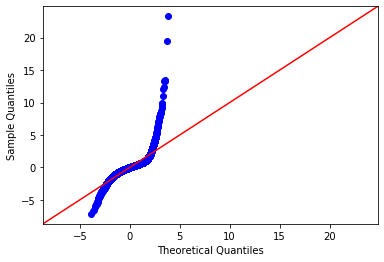

In [110]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

### Stepwise Selection

In [111]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 
          'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]',
         'had_reno*yr_updated_(1954.0, 1977.0]', 'had_reno*yr_updated_(1977.0, 1999.0]', 'had_reno*yr_updated_(1999.0, 2015.0]',
         'sqft_above_scaled*sqft_living15_scaled', 'sqft_above_scaled*bedrooms_scaled', 
          'sqft_above_scaled*floors_scaled', 'sqft_above_scaled*grade', 'sqft_above_scaled*sqft_lot',
         'bedrooms*grade']

X_train_cols = [col for col in X_train_int_features.columns if col not in m_cols]

In [112]:
if run_stepwise_selection:
    BidirectionalStepwiseSelection(X_train_int_features[X_train_cols],
                                   y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : sqft_living15_scaled 	AIC : 480594.9794201992
break : No need to Backward Elimination
Entered : dist_from_city 	AIC : 476942.8151735897
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 473896.24933837197
break : No need to Backward Elimination
Entered : waterfront__1 	AIC : 472416.2703068148
break : No need to Backward Elimination
Entered : grade_scaled 	AIC : 470931.769426489
break : No need to Backward Elimination
Entered : house_age 	AIC : 469153.12850449805
break : No need to Backward Elimination
Entered : _98004 	AIC : 467877.3620759414
break : No need to Backward Elimination
Entered : _98039 	AIC : 466618.8956978182
break : No need to Backward Elimination
Entered : has_basement__1 	AIC : 465602.29223899957
break : No need to Backward Elimination
Entered : view__4 	AIC : 465068.2982174319
break : No need to Backward Elimination
Entered : _9

AIC: 459216.6547048349
BIC: 459774.56975005666
Final Variables: ['intercept', 'sqft_living15_scaled', 'dist_from_city', 'sqft_above_scaled', 'waterfront__1', 'grade_scaled', 'house_age', '_98004', '_98039', 'has_basement__1', 'view__4', '_98040', '_98112', 'bathrooms_scaled*bedrooms_scaled', 'dist_from_city*waterfront__1', 'view__3', 'urban__1', 'condition_5', '_98117', 'view__2', '_98105', '_98103', '_98119', '_98102', '_98115', '_98199', '_98033', '_98109', 'sqft_lot', '_98107', '_98006', 'floors_scaled*split_level__1', 'bathrooms_scaled', 'view__1', '_98029', '_98177', '_98122', '_98027', '_98045', 'condition_4', '_98116', '_98136', '_98144', 'had_reno__1', '_98058', '_98178', 'season__1', '_98005', '_98133', '_98022', '_98125', '_98065', '_98010', '_98038', '_98024', '_98008', 'season__1*waterfront__1', '_98053', '_98075', '_98126', '_98002', 'new_build__1', '_98052', '_98007', '_98118', '_98034', '_98155', '_98074', '_98072', '_98014', '_98070', '_98106']


## Re-Run Model with Interactions

### Define Features

In [113]:
# columns chosen by stepwise selection
cols_to_include = ['grade_scaled', 'dist_from_city', 'waterfront__1', 'sqft_above_scaled', 'house_age', '_98004', '_98039', 'has_basement__1', 'view__4', '_98040', 'bathrooms_scaled*bedrooms_scaled', '_98112', 'dist_from_city*waterfront__1', 'view__3', 'urban__1', 'condition_5', '_98117', 'view__2', '_98105', '_98103', '_98102', '_98119', '_98033', '_98199', '_98115', '_98109', 'sqft_lot', '_98006', '_98107', 'floors_scaled*split_level__1', 'bathrooms_scaled', 'view__1', '_98029', '_98177', '_98122', '_98027', 'bedrooms*grade', 'condition_4', '_98045', '_98178', '_98116', '_98058', 'season__1', 'had_reno__1', 'sqft_living15_scaled', '_98136', '_98144', '_98005', '_98133', '_98125', '_98022', '_98008', '_98010', '_98065', '_98038', '_98024', 'season__1*waterfront__1', '_98075', '_98053', '_98126', '_98002', 'new_build__1', '_98007', '_98052', '_98118', '_98034', '_98155', '_98074', '_98072', '_98014', '_98070', 'split_level__1', '_98106']
# columns to add back because of interactions that are significant
cols_to_add = []
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [114]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [115]:
X_train_int_features_rerun = X_train[cols_to_include]
X_test_int_features_rerun = X_test[cols_to_include]

### Linear Regression sklearn

In [116]:
lin_reg_sklearn(X_train_int_features_rerun, X_test_int_features_rerun, y_train, y_test)

Training Set RMSE: 158937.89320611357
Test Set RMSE: 154062.19640826478

Training Set MAE: 93943.10857565355
Test Set MAE: 92427.61750488232

Cross Val RMSE: 161363.95252213615


### Linear Regression statsmodels

In [117]:
model_int_features = lin_reg_statsmodels(X_train_int_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1012.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:20:19   Log-Likelihood:            -2.2951e+05
No. Observations:               17134   AIC:                         4.592e+05
Df Residuals:                   17060   BIC:                         4.597e+05
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             4.518e+05   1.04e+04     43.613      0.000    4.31e+05    4.72e+05
_98002                            4.568e+04   1.32e+04      3.464      0.001    1.98e+04    7.15e+04
_98004                             6.34e+05   1.18e+04     53.625      0.000    6.11e+05    6.57e+05
_98005                            1.416e+05   1.48e+04      9.591      0.000    1.13e+05    1.71e+05
_98006                            1.475e+05   9153.571     16.113      0.000     1.3e+05    1.65e+05
_98007                            1.008e+05   1.66e+04      6.064      0.000    6.82e+04    1.33e+05
_98008                            1.008e+05   1.19e+04      8.453      0.000    7.75e+04    1.24e+05
_98010                            8.873e+04   1.86e+04      4.760      0.000    5.22e+04    1.25e+05
_98014                            5.689e+04   1.65e+04      3.446      0.001    2.45e+04    8.93e+04
_98022                            6.891e+04   1.35e+04      5.101      0.000    4.24e+04    9.54e+04
_98024                            1.092e+05   2.14e+04      5.092      0.000    6.71e+04    1.51e+05
_98027                            9.968e+04   9386.599     10.620      0.000    8.13e+04    1.18e+05
_98029                            1.392e+05   1.06e+04     13.134      0.000    1.18e+05     1.6e+05
_98033                            1.988e+05   1.04e+04     19.048      0.000    1.78e+05    2.19e+05
_98034                            5.674e+04   9412.581      6.028      0.000    3.83e+04    7.52e+04
_98038                                4e+04   8037.761      4.977      0.000    2.42e+04    5.58e+04
_98039                            1.258e+06   2.65e+04     47.553      0.000    1.21e+06    1.31e+06
_98040                            3.591e+05   1.18e+04     30.310      0.000    3.36e+05    3.82e+05
_98045                            1.166e+05   1.28e+04      9.104      0.000    9.15e+04    1.42e+05
_98052                             6.94e+04   9543.649      7.272      0.000    5.07e+04    8.81e+04
_98053                            7.181e+04   9979.710      7.196      0.000    5.22e+04    9.14e+04
_98058                            -2.67e+04   8519.096     -3.134      0.002   -4.34e+04   -9996.715
_98065                            6.223e+04   1.07e+04      5.797      0.000    4.12e+04    8.33e+04
_98070                            6.045e+04   1.81e+04      3.332      0.001    2.49e+04     9.6e+04
_98072                            4.488e+04   1.13e+04      3.964      0.000    2.27e+04    6.71e+04
_98074                            4.591e+04   9652.634      4.756      0.000     2.7e+04    6.48e+04
_98075                            6.511e+04   1.03e+04      6.350      0.000     4.5e+04    8.52e+04
_98102                            3.647e+05   1.82e+0

### Summary

There are improvements to R^2 and RMSE with the addition of interating features, but the model is getting complicated.

## Model with Polynomials

This model will have all the continuous, categorical, and interacting features, plus polynomial ones

### Define Feature Sets

In [118]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 
                  'yr_built', 'yr_renovated', 'sqft_above',
                 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 
                  'floors', 'grade', 'sqft_basement']
poly_cols = [col for col in X_train.columns if col not in cols_to_ignore]

# sort the column names for easier interpretation
poly_cols = sorted(poly_cols)
X_train_poly_features = X_train[poly_cols]
X_test_poly_features = X_test[poly_cols]

### Add polynomials

In [119]:
poly = PolynomialFeatures(3)
poly_grade_train = poly.fit_transform(X_train_poly_features['grade_scaled'].values.reshape(-1, 1))
poly_grade_test = poly.fit_transform(X_test_poly_features['grade_scaled'].values.reshape(-1, 1))

In [120]:
X_train_poly_features['grade^2'] = poly_grade_train[:, 2]
X_test_poly_features['grade^2'] = poly_grade_test[:, 2]
X_train_poly_features['grade^3'] = poly_grade_train[:, 3]
X_test_poly_features['grade^3'] = poly_grade_test[:, 3]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [121]:
poly2 = PolynomialFeatures(2)

In [122]:
poly_bathrooms_train = poly.fit_transform(X_train_poly_features['bathrooms_scaled'].values.reshape(-1, 1))
poly_bathrooms_test = poly.fit_transform(X_test_poly_features['bathrooms_scaled'].values.reshape(-1, 1))

X_train_poly_features['bathrooms^2'] = poly_bathrooms_train[:, 2]
X_test_poly_features['bathrooms^2'] = poly_bathrooms_test[:, 2]

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Linear Regression sklearn

In [123]:
lin_reg_sklearn(X_train_poly_features, X_test_poly_features, y_train, y_test)

Training Set RMSE: 144437.32193948532
Test Set RMSE: 145959.92539480657

Training Set MAE: 85855.02411698613
Test Set MAE: 86045.2535406069

Cross Val RMSE: 147932.92588464584


### Linear Regression statsmodels

In [124]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     806.9
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:20:22   Log-Likelihood:            -2.2787e+05
No. Observations:               17134   AIC:                         4.560e+05
Df Residuals:                   17018   BIC:                         4.569e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -1.639e+05   5.87e+04     -2.794      0.005   -2.79e+05   -4.89e+04
_98002                                  6333.2963   1.44e+04      0.441      0.659   -2.18e+04    3.45e+04
_98003                                 -1.244e+04    1.3e+04     -0.955      0.340    -3.8e+04    1.31e+04
_98004                                  6.098e+05    2.1e+04     29.082      0.000    5.69e+05    6.51e+05
_98005                                   1.63e+05   2.19e+04      7.438      0.000     1.2e+05    2.06e+05
_98006                                  1.347e+05   1.78e+04      7.554      0.000    9.97e+04     1.7e+05
_98007                                   1.18e+05   2.26e+04      5.221      0.000    7.37e+04    1.62e+05
_98008                                   1.16e+05   1.95e+04      5.934      0.000    7.77e+04    1.54e+05
_98010                                  6.324e+04   1.87e+04      3.373      0.001    2.65e+04       1e+05
_98011                                  2.317e+04   1.98e+04      1.170      0.242   -1.56e+04     6.2e+04
_98014                                  4.282e+04   1.87e+04      2.293      0.022    6220.495    7.94e+04
_98019                                  9558.0028   1.82e+04      0.526      0.599   -2.61e+04    4.52e+04
_98022                                  3.389e+04   1.58e+04      2.147      0.032    2949.581    6.48e+04
_98023                                 -2.012e+04   1.13e+04     -1.783      0.075   -4.22e+04    1999.817
_98024                                  1.068e+05   2.25e+04      4.740      0.000    6.26e+04    1.51e+05
_98027                                  9.053e+04   1.54e+04      5.887      0.000    6.04e+04    1.21e+05
_98028                                  1.983e+04   1.84e+04      1.077      0.282   -1.63e+04    5.59e+04
_98029                                  1.445e+05   1.62e+04      8.915      0.000    1.13e+05    1.76e+05
_98030                                 -2.092e+04   1.35e+04     -1.551      0.121   -4.73e+04    5515.269
_98031                                 -2.983e+04   1.42e+04     -2.094      0.036   -5.78e+04   -1910.044
_98032                                 -2.474e+04   1.73e+04     -1.432      0.152   -5.86e+04    9133.855
_98033                                  1.987e+05   2.02e+04      9.817      0.000    1.59e+05    2.38e+05
_98034                                  5.699e+04   1.87e+04      3.055      0.002    2.04e+04    9.35e+04
_98038                                  2.164e+04   1.11e+04      1.953      0.051     -74.998    4.34e+04
_98039                                  1.105e+06   3.01e+04     36.709      0.000    1.05e+06    1.16e+06
_98040                                  3.559e+05   1.95e+04     18.256      0.000    3

### Check for Multicolinearity

In [125]:
vif_analysis(X_train_poly_features)

Variance inflation factor for _98002: 1.54
Variance inflation factor for _98003: 1.73
Variance inflation factor for _98004: 4.64
Variance inflation factor for _98005: 2.91
Variance inflation factor for _98006: 5.4
Variance inflation factor for _98007: 2.33
Variance inflation factor for _98008: 3.7
Variance inflation factor for _98010: 1.28
Variance inflation factor for _98011: 2.54
Variance inflation factor for _98014: 1.57
Variance inflation factor for _98019: 2.19
Variance inflation factor for _98022: 2.18
Variance inflation factor for _98023: 2.3
Variance inflation factor for _98024: 1.34
Variance inflation factor for _98027: 3.24
Variance inflation factor for _98028: 3.29
Variance inflation factor for _98029: 2.81
Variance inflation factor for _98030: 1.8
Variance inflation factor for _98031: 1.96
Variance inflation factor for _98032: 1.4
Variance inflation factor for _98033: 5.85
Variance inflation factor for _98034: 6.3
Variance inflation factor for _98038: 2.61
Variance inflatio

### Residuals

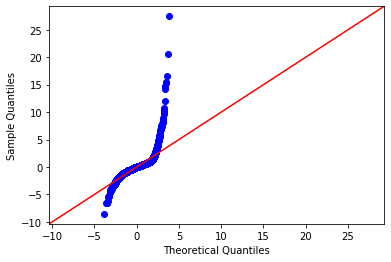

In [126]:
sm.graphics.qqplot(model_int_features.resid, line='45', fit=True);

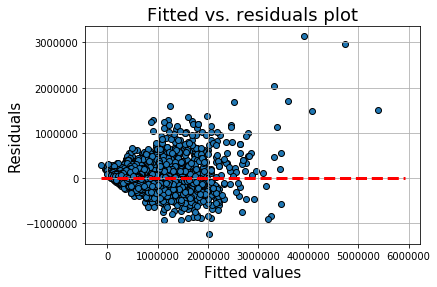

In [127]:
p=plt.scatter(x=model_poly_features.fittedvalues,y=model_poly_features.resid,edgecolor='k')
xmin=min(model_poly_features.fittedvalues)
xmax = max(model_poly_features.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

### Stepwise Selection

Remove the columns with multicolinearity issues before running stepwise selection.

In [128]:
# columns with multicolinearity issues
m_cols = ['floors_scaled', 'bedrooms_scaled', 
          'yr_updated_(1954.0, 1977.0]', 'yr_updated_(1977.0, 1999.0]', 'yr_updated_(1999.0, 2015.0]',
         'had_reno*yr_updated_(1954.0, 1977.0]', 'had_reno*yr_updated_(1977.0, 1999.0]', 'had_reno*yr_updated_(1999.0, 2015.0]',
         'sqft_above_scaled*sqft_living15_scaled', 'sqft_above_scaled*bedrooms_scaled', 
          'sqft_above_scaled*floors_scaled', 'sqft_above_scaled*grade', 'sqft_above_scaled*sqft_lot',
         'bedrooms*grade']

X_train_cols = [col for col in X_train_poly_features.columns if col not in m_cols]

In [129]:
if run_stepwise_selection:
    BidirectionalStepwiseSelection(X_train_poly_features[X_train_cols], 
                                   y_train, elimination_criteria='aic')

Character Variables (Dummies Generated, First Dummies Dropped): []
break : No need to Backward Elimination
Entered : bathrooms^2 	AIC : 484854.26909979054
break : No need to Backward Elimination
Entered : grade^3 	AIC : 478034.25384517654
break : No need to Backward Elimination
Entered : bathrooms_scaled 	AIC : 476316.067165366
break : No need to Backward Elimination
Entered : house_age 	AIC : 474563.5778739834
break : No need to Backward Elimination
Entered : sqft_above_scaled 	AIC : 473074.7407160204
break : No need to Backward Elimination
Entered : grade_scaled 	AIC : 471220.73791378725
break : No need to Backward Elimination
Entered : _98004 	AIC : 469654.8092276302
break : No need to Backward Elimination
Entered : urban__1 	AIC : 467583.80101638025
break : No need to Backward Elimination
Entered : view__4 	AIC : 466015.39522421424
break : No need to Backward Elimination
Entered : dist_from_city 	AIC : 464857.387159036
break : No need to Backward Elimination
Entered : _98039 	AIC :

## Re-Run Polynomial Model

### Define Features

In [130]:
# columns chosen by stepwise selection
cols_to_include = ['grade^3', 'bathrooms_scaled', 'house_age', '_98004', 'urban__1', 'view__4', 'sqft_living15_scaled', 'dist_from_city', 'sqft_above_scaled', '_98039', 'waterfront__1', '_98040', '_98112', 'has_basement__1', 'dist_from_city*waterfront__1', 'view__3', 'grade^2', 'grade_scaled', '_98117', 'condition_5', 'view__2', '_98105', '_98103', '_98119', '_98115', '_98199', '_98102', '_98033', '_98109', '_98107', 'view__1', 'condition_4', 'bathrooms_scaled*bedrooms_scaled', '_98029', 'sqft_lot', 'had_reno__1', '_98177', '_98122', 'floors_scaled*split_level__1', '_98045', '_98006', '_98178', '_98116', '_98136', '_98027', '_98144', '_98005', 'season__1', '_98133', '_98125', '_98022', 'new_build__1', '_98008', '_98058', 'season__1*waterfront__1', '_98053', '_98052', '_98065', '_98168', '_98075', '_98007', '_98126', '_98024', '_98038', '_98010', '_98074', '_98155', '_98034', '_98072', '_98118', '_98070', '_98014', 'split_level__1', '_98028']
# columns to add back because of interactions that are significant
cols_to_add = ['bedrooms_scaled', 'floors_scaled']
# combine the lists
cols_to_include = cols_to_include + cols_to_add

In [131]:
# sort the column names for easier interpretation
cols_to_include = sorted(cols_to_include)

In [132]:
X_train_poly_features_rerun = X_train_poly_features[cols_to_include]
X_test_poly_features_rerun = X_test_poly_features[cols_to_include]

### Linear Regression sklearn

In [133]:
lin_reg_sklearn(X_train_poly_features_rerun, X_test_poly_features_rerun, y_train, y_test)

Training Set RMSE: 148042.1801788443
Test Set RMSE: 147329.4777074846

Training Set MAE: 87498.92762862009
Test Set MAE: 87422.31012693197

Cross Val RMSE: 150574.4627397858


### Linear Regression statsmodels

In [134]:
model_poly_features = lin_reg_statsmodels(X_train_poly_features_rerun, y_train)

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1154.
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        15:25:33   Log-Likelihood:            -2.2830e+05
No. Observations:               17134   AIC:                         4.567e+05
Df Residuals:                   17057   BIC:                         4.573e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.902e+05   8040.838     48.526      0.000    3.74e+05    4.06e+05
_98004                            6.206e+05    1.1e+04     56.274      0.000    5.99e+05    6.42e+05
_98005                            1.582e+05   1.38e+04     11.493      0.000    1.31e+05    1.85e+05
_98006                            1.338e+05   8553.758     15.644      0.000    1.17e+05    1.51e+05
_98007                            1.129e+05   1.55e+04      7.288      0.000    8.25e+04    1.43e+05
_98008                            1.129e+05   1.11e+04     10.157      0.000    9.11e+04    1.35e+05
_98010                            7.227e+04   1.74e+04      4.165      0.000    3.83e+04    1.06e+05
_98014                            5.444e+04   1.54e+04      3.536      0.000    2.43e+04    8.46e+04
_98022                            6.299e+04   1.25e+04      5.051      0.000    3.85e+04    8.74e+04
_98024                            1.086e+05      2e+04      5.435      0.000    6.94e+04    1.48e+05
_98027                            9.827e+04   8768.501     11.207      0.000    8.11e+04    1.15e+05
_98028                            2.402e+04   1.04e+04      2.301      0.021    3557.517    4.45e+04
_98029                            1.541e+05   9893.127     15.577      0.000    1.35e+05    1.73e+05
_98033                            1.986e+05   9713.959     20.443      0.000     1.8e+05    2.18e+05
_98034                            5.389e+04   8760.114      6.151      0.000    3.67e+04    7.11e+04
_98038                            3.784e+04   7450.470      5.079      0.000    2.32e+04    5.24e+04
_98039                            1.166e+06   2.47e+04     47.145      0.000    1.12e+06    1.21e+06
_98040                            3.617e+05   1.11e+04     32.723      0.000     3.4e+05    3.83e+05
_98045                            1.168e+05   1.19e+04      9.824      0.000    9.35e+04     1.4e+05
_98052                            8.827e+04   8898.734      9.919      0.000    7.08e+04    1.06e+05
_98053                            8.623e+04   9332.073      9.240      0.000    6.79e+04    1.05e+05
_98058                           -2.068e+04   7947.422     -2.602      0.009   -3.63e+04   -5099.334
_98065                            6.705e+04   9996.591      6.707      0.000    4.75e+04    8.66e+04
_98070                            6.799e+04   1.69e+04      4.023      0.000    3.49e+04    1.01e+05
_98072                            5.883e+04   1.06e+04      5.564      0.000    3.81e+04    7.95e+04
_98074                            5.861e+04   9025.233      6.494      0.000    4.09e+04    7.63e+04
_98075                            7.069e+04   9598.247      7.365      0.000    5.19e+04    8.95e+04
_98102                            3.604e+05    1.7e+0

### Summary

The model with added polynomial features, showed a small improvement in R^2 and RSME

# Summary Analysis of the Models

## The predictive models

Four main multivariate linear regression models were made to predict housing prices using the *King County Housing Data Set*.  The first was the baseline model, the simplest, and the three others each increased in complexity and accuracy.

**The simple (baseline) model** This model started with ten continuous numerical features, eight that were provided and two that were derived from features in the model.  The numerical features in the dataset suffered from a lot of multicolinearity so a majority of them were standardized (the mean was subtracted) and this minimized the multicolinearity issues.

The R^2 for the revised baseline model (with the multicolinearity and features with high p-values removed) is 0.65 and the RMSE is 218,000.  Neither of those metrics is very good.  We are only explaining 65% of the data and our mean error is \\$218K.  The mean price in the training set is \\$540K and the standard deviation is \\$367K so at least the mean error is under one standard deviation, but it is not good enough to help a perspective buyer find a house in the range of the mean.

**Simple + Categoricals Model**  This model added over eighty categorical features to the simple model, the bulk of which are one hot encoded zipcodes.  After running a stepwise selection algorithm and accounting for features with multicolinearity the total number of features in the model ended up being seventy four.

The complexity of this model increased seven fold, but there was a significant payoff in accuracy.  The R^2 increased to 0.8 and the RMSE was reduced to 167,000.  This model reduced the mean error to under 1/2 the standard deviation of the actual prices, which is better than our baseline, but still not great.

Even though there are over seventy features in this model, they are easy to understand. The one hot encoded features are either there or not, and then the continuous linear ones from the baseline model.

**Simple + Categoricals + Interactions Model** This model added the element of features interacting with each other to be more then the sum of those interacting features.  Thirteen interacting terms were added to the model, but after considering the p-values during a stepwise selection and resolving multicolinearity issues only four remained.

This model had a small improvement in the accuracy metrics.  R^2 increased to 0.81 and RMSE was reduced to 160,000.

**Simple + Categoricals + Interactions + Polynomials Model** In this model polynomial terms were added.  There was only one feature that had what looked to be an obvious quadratic relationship with the target; that feature is grade.

Again for the price of complexity, the accuracy metrics improved.  R^2 increased to 0.84 and RMSE was reduced to 150,000.

**Conclusions on Models** None of them are sufficient for launching our business, but they are a step in the right direction.  An expert could do a better job making predictions, but of course not at the scale and speed of our models.

Zillow lists their accuracy for Seattle to have a median error of 2.2%, which for this dataset would be under $10,000.

To make improvements to our model, we need additional data.  To start, better location information, neighborhood level, historical price information for each house and real time localized information about the housing market.  If more time was alloted for this initial modeling phase, the neighborhood data could have been retrieved from one of the mapping services. The King County assessor has the historical price information and it is public information.  To get real time housing market information, we would need to monitor the assessor's office for updates to their system, or however housing sales are reported in a locality.



## Interpreting the Coefficients of the Models

Below are three examples of features and their coefficients, a standard feature, a polynomial and an interaction.

**sqft_above** The number of square feet of living area not in the basement is the feature with the most correlation with the target price that was used in the model.  In the final model its coefficient was 144.25, which would mean that for every additional sqft of living area the mean sale price would increase by \\$144.25 with a standard error of \\$3.38 per sqft

**grade** The grade for the house is a feature that was found to have a significant polynomial relationship with the price.  The grade for the house had a range of integers from 3 to 13.

The coefficients for grade are 
* grade: 23,120
* grade squared: 16,410
* grade cubed: 5,721

Because it is a polynomial, this isn't as straight forward as sqft_above.  Although for each increase of 1 in the grade the mean price will increase by \\$23,120, the grade^2 and grade^3 will increase at increasing rates depending on the actual value of grade.

**bedrooms and bathrooms** They were found to be interacting features.  They were treated as continuous features, but they had a finite number of options; bedrooms between 1 and 11, and bathrooms between 0.5 and 8.

The coefficients are:
* bedrooms -4,839
* bathrooms 36,470
* bedrooms\*bathrooms 11,030

Bedrooms has a negative coefficient so its value needs to lower the value of the interacting term.

To interpret the coefficients we have to look at two cases.  A change in bedrooms and a change in bathrooms.
* change in bedrooms - for a specific value of the mean centered value of bathrooms, an increase of one bedroom would be -4,839 + 11,030 \* bathrooms. EX for 2 bathrooms it would be -4,839 + 11,030 \* (2 - bathrooms.mean()) = -6,184
* change in bathrooms - for a specific value of  the mean centered value of bedrooms, an increase in one bathroom would be 36,470 + 11,030\* bedrooms. EX for 3 bedrooms it would be 36,470 + 11,030\* (3 - bedrooms.mean()) = 32,383

This relationship can be understood to mean that house buyers want a sufficient number of bathrooms compared to bedrooms.  Adding a bathroom is more valuable than adding a bedroom.

In the above examples, it might seem strange that the house price would actually drop by adding a bedroom when there are 2 bathrooms, but it is not true for all values of bathrooms, once 2.75 bathrooms is reached the house price does increase when bedrooms are added.

It is also the case that "strange" bathroom/bedroom combos that don't exist in the dataset nor are likely to exist would not be explained by the model, such as a house with 5 bathrooms but only one bedroom.
